In [1]:
# this experiment is about noising Default Model with Dense architecture

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
BATCH_SIZE = 128

In [6]:
save_model=True

In [7]:
!mkdir saved_models2

mkdir: cannot create directory ‘saved_models2’: File exists


In [8]:
save_path=r'saved_models2/'

In [9]:
os.environ['KERAS_HOME'] = os.path.join(os.getcwd(),'keras','datasets')

In [10]:
mnist_path = os.path.join(os.getcwd(),'keras','datasets/mnist.npz')
mnist_path

'/home/mluser_2/CNN_Work/keras/datasets/mnist.npz'

In [11]:
n_epochs = 30
num_classes = 10


In [12]:
data_mean = 0.1307
data_std = 0.3081

## Some useful functions

In [13]:
def preprocess_img(x):
   # x = (x.astype('float32')-data_mean)/data_std #or x.astype('float32')/255.0
    x = x.astype('float32')/255.0
    x = np.reshape(x, (len(x),28,28,1))
    return x

In [14]:
def preprocess_labels(y):
    return tf.one_hot(y.astype(np.int32), depth=num_classes)

In [15]:
# find index of images with different classes true&pred
def find_diff_classes(y_true, y_pred, n=10000):    
    diff_classes_lst = []
    for i in range(n):
        if np.argmax(y_true[i])!= np.argmax(y_pred[i]):
            #print(np.argmax(y_true[i]),np.argmax(y_pred[i]), i)
            diff_classes_lst.append(i)
    return diff_classes_lst

In [16]:
# display images+true labels from one set
def display_one_batch_(x, y, title ='', n=10):
    indices = np.arange(0,10,1)
    imgs_1 = x[indices,:] 
    
    fig=plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.title(f'True label: {np.argmax(y[i])}') #for normilized images
        #plt.title(f'True label: {y[i]}')
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle(title, y=1.05, fontsize=20)
    #fig.savefig('name')
    plt.show()

In [78]:
# display images+true labels from one set
def display_true_pred_pair(x, y_pred, y_true, title ='', n=10):
    indices = np.arange(0,10,1)
    imgs_1 = x[indices,:] 
    
    fig=plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        true_title = f'True label: {np.argmax(y_true[i])}'
        pred_title = f'Pred label: {np.argmax(y_pred[i])}'
        plt.title(f'{true_title}\n{pred_title}\n', fontsize=14)
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle(title, y=1.2, fontsize=25)
    #fig.savefig('name')
    plt.show()

In [17]:
#display pair of images
def display_pair(x1, x2, n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    plt.figure(figsize=(20,4))
    for i, (img1, img2) in enumerate(zip(imgs_1,imgs_2)):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [18]:
#display pair of images: Original and Cleaned from noise
def display_pair2(x1, x2, n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    fig = plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle('Original images',fontsize=20)     
    
    fig2 = plt.figure(figsize=(20,4))
    for i,  img2 in enumerate(imgs_2):
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig2.suptitle('Cleaned images',y=0.05, fontsize=20)
    
    plt.show()

In [19]:
#display one pair of images: original and adversarial with their labels
def display_one_pair(x, x_adv, perturbation, y_true, y_pred):
    
    plt.figure(figsize=(20,2))
    fig, ax =plt.subplots(1, 4, figsize=(10,5))
    
    ax[0].imshow(x)
    ax[0].axis('off')
    ax[0].set_title('Original image', fontsize=15)
    ax[0].text(0.5, -0.13, f'True label: {np.argmax(y_true)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[1].imshow(perturbation)
    ax[1].axis('off')
    ax[1].set_title('Perturbation', fontsize=15)
    
    
    ax[2].imshow(x_adv)
    ax[2].axis('off')
    ax[2].set_title('Adversarial image', fontsize=15)
    ax[2].text(2.9, -0.13, f'Pred label: {np.argmax(y_pred)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[3].axis('off')
    plt.show()

In [20]:
#display one pair of images: original and adversarial with their labels
def display_quad(x, x_adv, perturbation, x_cleaned, y_true, y_pred_adv, y_pred_clean):
    
    plt.figure(figsize=(20,2))
    fig, ax =plt.subplots(1, 5, figsize=(10,5))
    
    ax[0].imshow(x)
    ax[0].axis('off')
    ax[0].set_title('Original', fontsize=15)
    ax[0].text(0.5, -0.13, f'True label: {np.argmax(y_true)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[1].imshow(perturbation)
    ax[1].axis('off')
    ax[1].set_title('Perturbation', fontsize=15)
    
    
    ax[2].imshow(x_adv)
    ax[2].axis('off')
    ax[2].set_title('Adversarial', fontsize=15)
    ax[2].text(2.9, -0.13, f'Pred label: {np.argmax(y_pred_adv)}', size=12,ha='center', transform=ax[0].transAxes)

    ax[3].imshow(x_adv)
    ax[3].axis('off')
    ax[3].set_title('Cleaned', fontsize=15)
    ax[3].text(4.2, -0.13, f'Pred label: {np.argmax(y_pred_clean)}', size=12,ha='center', transform=ax[0].transAxes)
    
    ax[4].axis('off')
    plt.show()

## Preprocess the mnist Dataset

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(mnist_path) 

In [22]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [23]:
x_train = preprocess_img(x_train)
x_test = preprocess_img(x_test)
x_train.shape

(60000, 28, 28, 1)

In [24]:
y_train = preprocess_labels(y_train)
y_test = preprocess_labels(y_test)

In [25]:
y_train.shape, y_test.shape

(TensorShape([60000, 10]), TensorShape([10000, 10]))

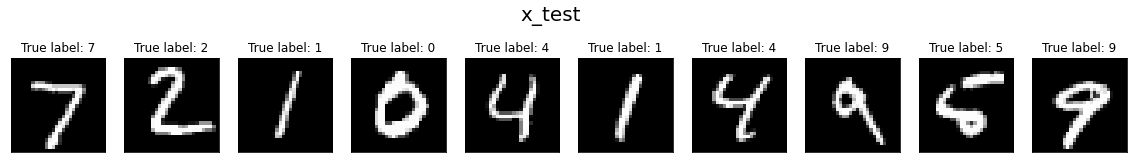

In [30]:
display_one_batch_(x_test, y_test, 'x_test')

## Default model

In [43]:
input_shape=(28,28,1)

In [44]:
input_imgs = Input(input_shape)
x=Flatten()(input_imgs)
x=Dense(512, activation='relu')(x)
x=Dropout(0.2)(x)

outputs=Dense(10, activation='softmax')(x)

In [45]:
model_2 = Model(inputs=input_imgs, outputs=outputs, name='mnist_default_model_dense_architecture')
model_2.summary()

Model: "mnist_default_model_dense_architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae','acc'])

In [47]:
model_2.fit(x_train, y_train,
         batch_size=BATCH_SIZE,
         epochs=n_epochs,
         validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


60000/60000 [==============================] - 5s 78us/sample - loss: 0.2792 - mae: 0.0293 - acc: 0.9199 - val_loss: 0.1315 - val_mae: 0.0146 - val_acc: 0.9611
Epoch 2/30
60000/60000 [==============================] - 5s 78us/sample - loss: 0.1221 - mae: 0.0133 - acc: 0.9636 - val_loss: 0.0981 - val_mae: 0.0106 - val_acc: 0.9708
Epoch 3/30
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0836 - mae: 0.0093 - acc: 0.9750 - val_loss: 0.0832 - val_mae: 0.0087 - val_acc: 0.9728
Epoch 4/30
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0637 - mae: 0.0073 - acc: 0.9802 - val_loss: 0.0689 - val_mae: 0.0069 - val_acc: 0.9791
Epoch 5/30
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0497 - mae: 0.0059 - acc: 0.9847 - val_loss: 0.0665 - val_mae: 0.0064 - val_acc: 0.9814
Epoch 6/30
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0401 - mae: 0.0048 - acc: 0.9880 - val_loss: 0.0670 - val_mae: 0.0060 - v

In [48]:
if save_model==True:
    model_2.save(os.path.join(save_path, 'mnist_default_model_dense_architecture'))
    model_2.save_weights(os.path.join('weights',"mnist_default_model_dense_architecture.ckpt"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: saved_models2/mnist_default_model_dense_architecture/assets


INFO:tensorflow:Assets written to: saved_models2/mnist_default_model_dense_architecture/assets


In [49]:
model_2.save(os.path.join(save_path, 'mnist_default_model_dense_architecture.h5'))

In [81]:
#test loading the model
loaded_model_mnist_2 = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model_dense_architecture.h5'))
loaded_model_mnist_2.evaluate(x_test,y_test)

ERROR! Session/line number was not unique in database. History logging moved to new session 659
10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.08028606160350779, 0.0037516835, 0.9829]

In [82]:
loaded_model_mnist_2.summary()

Model: "mnist_default_model_dense_architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [52]:
default_score_2 = model_2.evaluate(x_test,y_test)


10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

loss: 0.08028606160350779 mae: 0.0037516835145652294 accuracy: 0.9829000234603882


In [145]:
print(f'Default model score:\nloss: {default_score_2[0]} mae: {default_score_2[1]} accuracy: {default_score_2[2]}')

Default model score:
loss: 0.08028606160350779 mae: 0.0037516835145652294 accuracy: 0.9829000234603882


In [34]:
preds_default_2 = loaded_model_mnist_2.predict(x_test)


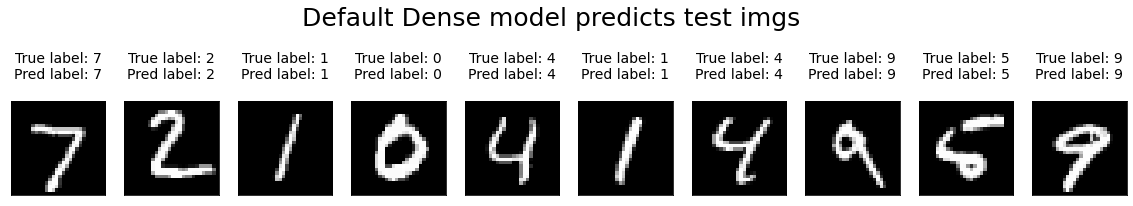

In [77]:
display_true_pred_pair(x_test, y_test, preds_default_2, 'Default Dense model predicts test imgs')

## ATTACKS

### FGSM

In [80]:
def create_perturbation_fgsm(model_fn, input_img, true_label):
    
    loss_func = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE или SparseCategoricalCrossentropy
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        loss = loss_func(true_label, prediction)
        
    #Get the gradients for the loss
    gradient = gt.gradient(loss, input_img)
    # Get the sign of the gradients to create the perturbation
    perturbation = tf.sign(gradient)
    
    return perturbation

# Func for fgsm attack on the whole dataset. Return perturbations and adversarial images of input dataset len
def FGSM(model_fn, dataset_name, epsilon=0.3):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]
        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
       
        perturbations[i] = create_perturbation_fgsm(model_fn, image, label)
        
        adv_imgs[i] = image + perturbations[i]*epsilon
    #return perturbations
    return perturbations, adv_imgs

ERROR! Session/line number was not unique in database. History logging moved to new session 658


In [83]:
name = 'test'
x_test_fgsm_perts2, x_test_fgsm_imgs2 = FGSM(loaded_model_mnist_2, name, epsilon=0.05)


In [84]:
test_fgsm_preds2 = loaded_model_mnist_2.predict(x_test_fgsm_imgs2)
fgsm_eval_defaut_model2 = loaded_model_mnist_2.evaluate(x_test_fgsm_imgs2, y_test)


ERROR! Session/line number was not unique in database. History logging moved to new session 660
10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [85]:
print(f'Default model on fgsm_adv_images:\n loss: {fgsm_eval_defaut_model2[0]} mae: {fgsm_eval_defaut_model2[1]} accuracy: {fgsm_eval_defaut_model2[2]}') 

Default model on fgsm_adv_images:
 loss: 5.1034277147293095 mae: 0.08553943783044815 accuracy: 0.5701000094413757


[0, 2, 4, 5, 6, 8, 9]


<Figure size 1440x144 with 0 Axes>

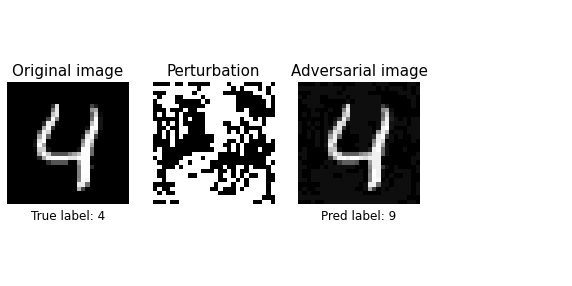

In [230]:
x_x_adv_fgsm2 = find_diff_classes(y_test, test_fgsm_preds2, n=10)
print(x_x_adv_fgsm2) 
display_one_pair(x_test[4], x_test_fgsm_imgs2[4], x_test_fgsm_perts2[4], y_test[4], test_fgsm_preds2[4])


<Figure size 1440x144 with 0 Axes>

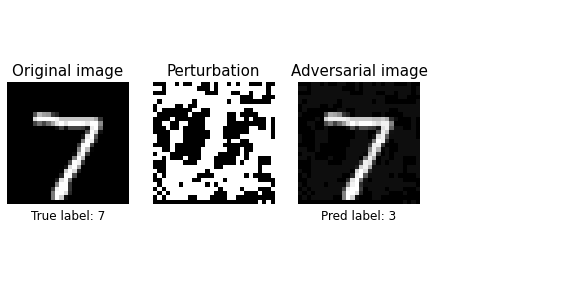

<Figure size 1440x144 with 0 Axes>

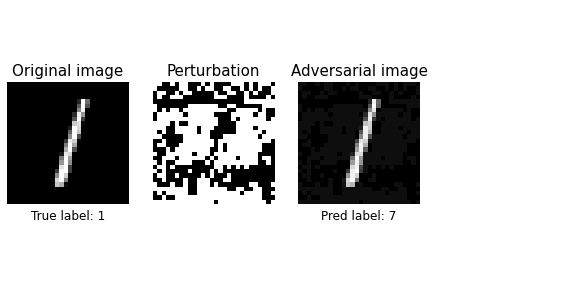

<Figure size 1440x144 with 0 Axes>

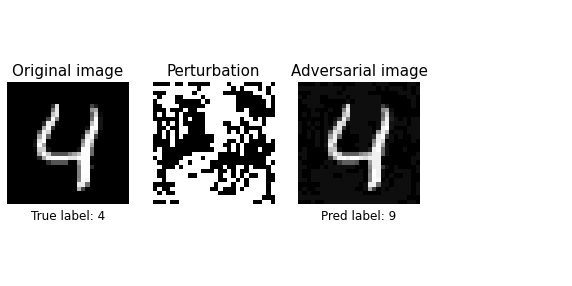

<Figure size 1440x144 with 0 Axes>

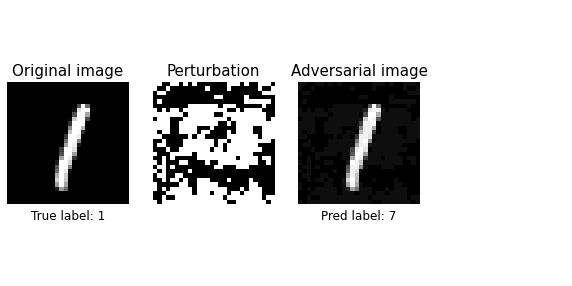

<Figure size 1440x144 with 0 Axes>

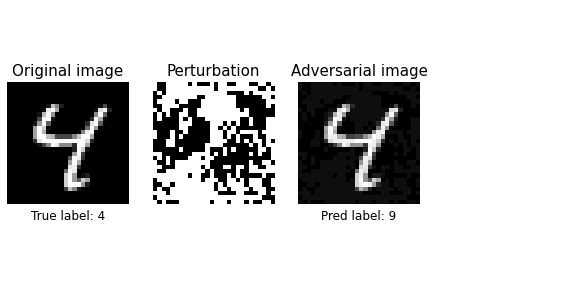

<Figure size 1440x144 with 0 Axes>

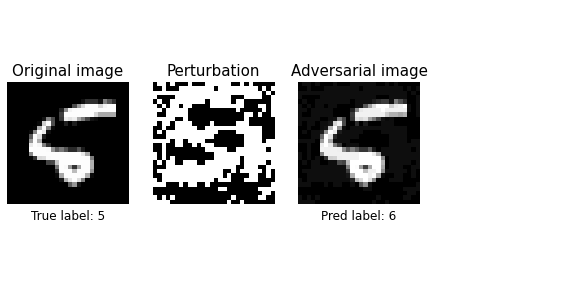

<Figure size 1440x144 with 0 Axes>

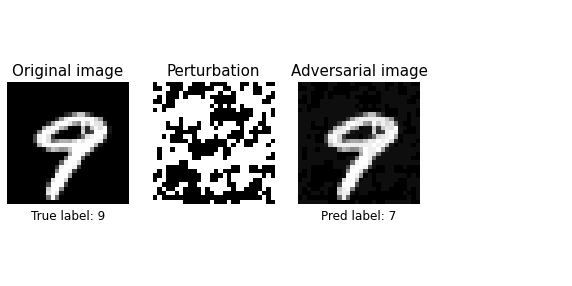

In [221]:
for idx in x_x_adv_fgsm2:
    display_one_pair(x_test[idx], x_test_fgsm_imgs2[idx], x_test_fgsm_perts2[idx], y_test[idx], test_fgsm_preds2[idx])

### ONESTEPLESSLIKELY

In [69]:
def create_perturbation_oneStep(model_fn, input_img, eps):
    
    loss_func = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE или SparseCategoricalCrossentropy
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        #compute least likely predicted label for clean image
        y_ll = tf.math.argmin(prediction, 1)
        loss = loss_func(y_ll, prediction)
        
    #Get the gradients for the loss
    gradient = gt.gradient(loss, input_img)
    perturbation = eps*tf.sign(gradient)
    
    return perturbation

def OneStepLeastLikely(model_fn, dataset_name, epsilon):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]
        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
       
        perturbations[i] = create_perturbation_oneStep(model_fn, image, epsilon)
        
        adv_imgs[i] = image - perturbations[i]
    #return perturbations
    return perturbations, adv_imgs

In [318]:
name = 'test'
x_test_onest_perts2, x_test_onest_imgs2 = OneStepLeastLikely(model_2, name, epsilon=0.05)

In [319]:
test_onest_preds2 = model_2.predict(x_test_onest_imgs2)
onest_eval_defaut_model_2 = model_2.evaluate(x_test_onest_imgs2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [320]:
print(f'Default model on onesteplesslikely_adv_images:\n loss: {onest_eval_defaut_model_2[0]} mae: {onest_eval_defaut_model_2[1]} accuracy: {onest_eval_defaut_model_2[2]}') 


Default model on onesteplesslikely_adv_images:
 loss: 3.28247016556263 mae: 0.06545880436897278 accuracy: 0.6704999804496765


In [225]:
x_x_adv_imgs_onest2 = find_diff_classes(y_test, test_onest_preds2, n=10)
x_x_adv_imgs_onest2

[0, 4, 5, 6, 8, 9]

<Figure size 1440x144 with 0 Axes>

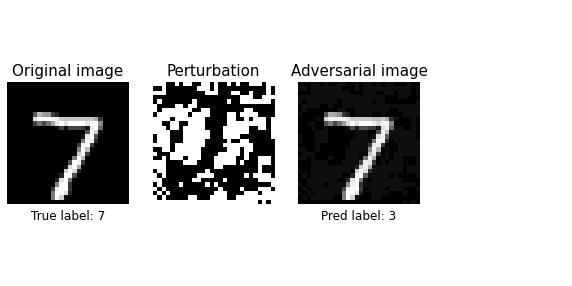

<Figure size 1440x144 with 0 Axes>

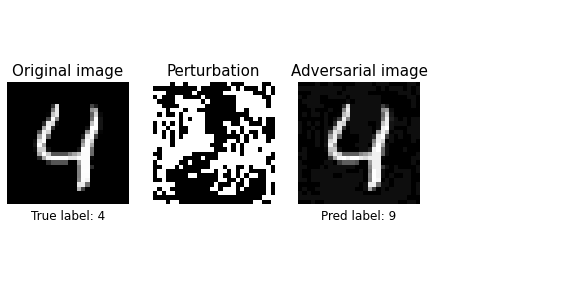

<Figure size 1440x144 with 0 Axes>

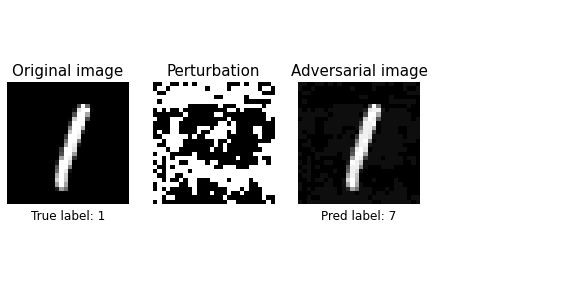

<Figure size 1440x144 with 0 Axes>

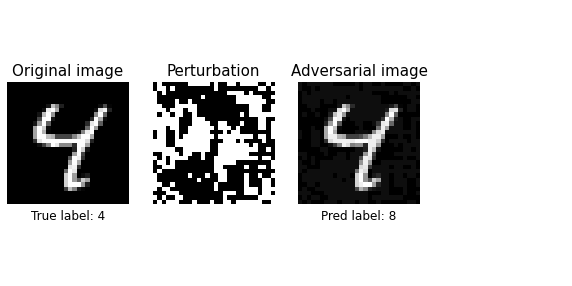

<Figure size 1440x144 with 0 Axes>

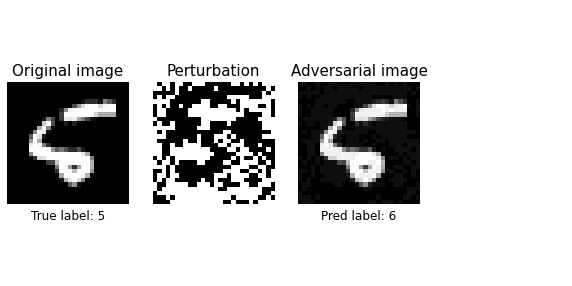

<Figure size 1440x144 with 0 Axes>

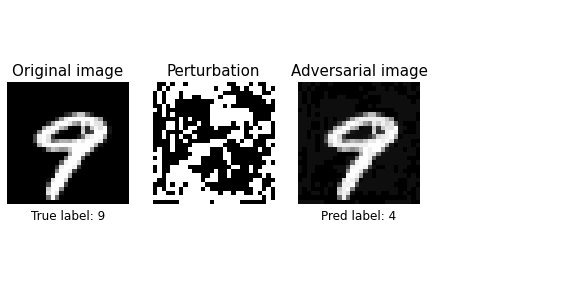

In [226]:

for idx in x_x_adv_imgs_onest2:
    display_one_pair(x_test[idx], x_test_onest_imgs2[idx], x_test_onest_perts2[idx], y_test[idx], test_onest_preds2[idx])

### BIM

In [93]:
# Func for fgsm attack on the whole dataset. Return perturbations and adversarial images of input dataset len
def BIM(model_fn, dataset_name, epsilon=0.3):
    if dataset_name == 'train':
        dataset = x_train
        labels = y_train
    elif dataset_name == 'test':
        dataset = x_test
        labels = y_test
    else:
        return r'Choose dataset name: train/test!'
    
    perturbations = np.empty([len(dataset),28,28,1])
    adv_imgs = np.empty([len(dataset),28,28,1])
    for i in range(len(dataset)):
        image = dataset[i]
        image = np.expand_dims(image, axis=0)
        label = labels[i]
        
        image = tf.convert_to_tensor(image, dtype = tf.float32)
       
        perturbations[i] = create_perturbation_fgsm(model_fn, image, label)
        
        adv_imgs[i] = image - perturbations[i]*epsilon
    #return perturbations
    return perturbations, adv_imgs

ERROR! Session/line number was not unique in database. History logging moved to new session 664


In [94]:
model_2 = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model_dense_architecture.h5'))

ERROR! Session/line number was not unique in database. History logging moved to new session 665


In [95]:
name = 'test'
x_test_bim_perts2, x_test_bim_imgs2 = BIM(model_2, name, epsilon=0.4)

ERROR! Session/line number was not unique in database. History logging moved to new session 668


In [96]:
test_bim_preds2 = model_2.predict(x_test_bim_imgs2)
bim_eval_defaut_model_2 = model_2.evaluate(x_test_bim_imgs2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [97]:
print(f'Default model on bim_adv_images:\n loss: {bim_eval_defaut_model_2[0]} mae: {bim_eval_defaut_model_2[1]} accuracy: {bim_eval_defaut_model_2[2]}') 

Default model on bim_adv_images:
 loss: 0.19573365180921418 mae: 0.0026656168047338724 accuracy: 0.9868999719619751


In [98]:
x_x_adv_imgs_bim2 = find_diff_classes(y_test, test_bim_preds2)
x_x_adv_imgs_bim2

[65,
 94,
 125,
 264,
 266,
 344,
 365,
 403,
 490,
 530,
 542,
 582,
 681,
 717,
 862,
 1086,
 1191,
 1202,
 1309,
 1425,
 1428,
 1435,
 1438,
 1441,
 1525,
 1594,
 1621,
 1641,
 1782,
 1785,
 1787,
 1788,
 2001,
 2093,
 2177,
 2185,
 2272,
 2393,
 2473,
 2493,
 2544,
 2571,
 2631,
 2633,
 2654,
 2705,
 2794,
 2858,
 2939,
 3012,
 3219,
 3305,
 3388,
 3464,
 3466,
 3520,
 3559,
 3567,
 3598,
 3646,
 3781,
 3861,
 3864,
 3874,
 3954,
 4088,
 4095,
 4101,
 4146,
 4293,
 4380,
 4399,
 4419,
 4429,
 4477,
 4505,
 4555,
 4639,
 4641,
 4665,
 4737,
 4823,
 5017,
 5176,
 5183,
 5209,
 5231,
 5331,
 5678,
 5951,
 6137,
 6228,
 6230,
 6347,
 6555,
 6567,
 6617,
 6641,
 6851,
 6870,
 7094,
 7216,
 7444,
 7534,
 7586,
 7640,
 7864,
 7971,
 8273,
 8325,
 8332,
 8374,
 8408,
 8467,
 8477,
 8534,
 8599,
 8690,
 8893,
 8963,
 9069,
 9079,
 9089,
 9094,
 9112,
 9142,
 9316,
 9404,
 9630,
 9677,
 9826]

<Figure size 1440x144 with 0 Axes>

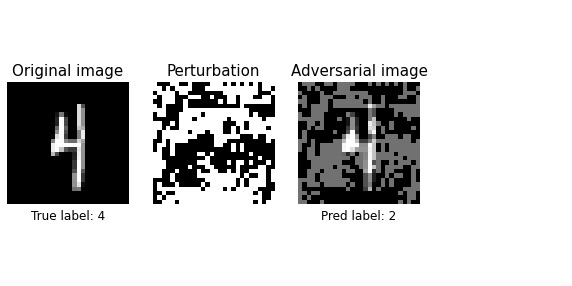

<Figure size 1440x144 with 0 Axes>

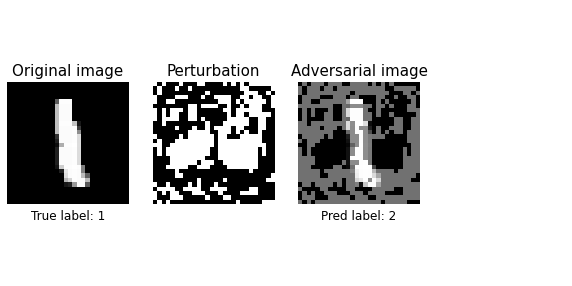

<Figure size 1440x144 with 0 Axes>

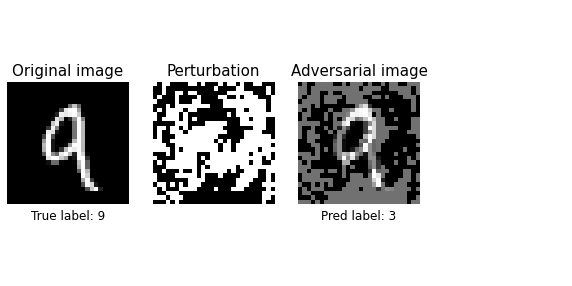

<Figure size 1440x144 with 0 Axes>

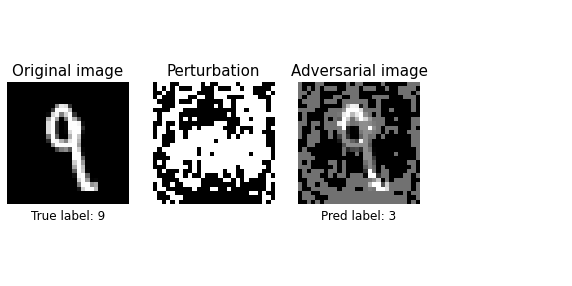

<Figure size 1440x144 with 0 Axes>

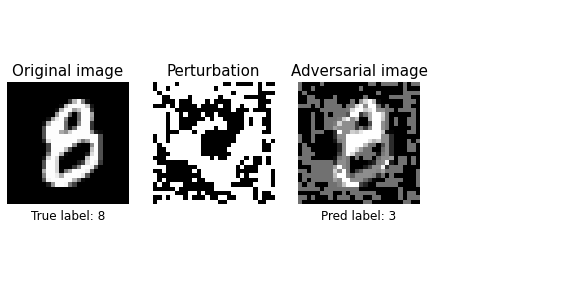

<Figure size 1440x144 with 0 Axes>

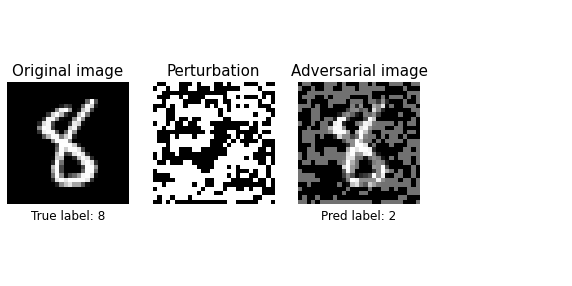

<Figure size 1440x144 with 0 Axes>

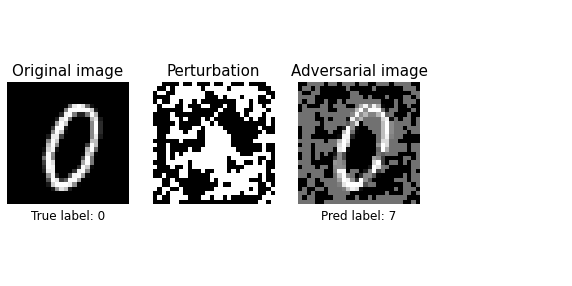

<Figure size 1440x144 with 0 Axes>

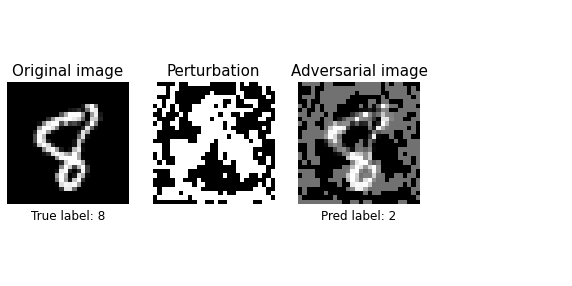

<Figure size 1440x144 with 0 Axes>

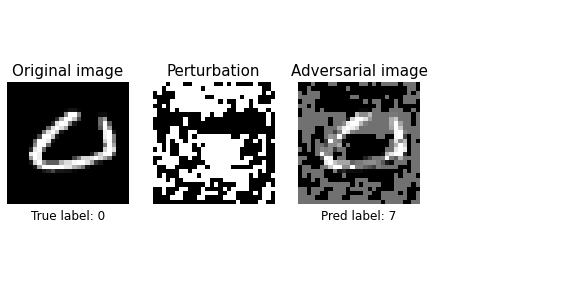

<Figure size 1440x144 with 0 Axes>

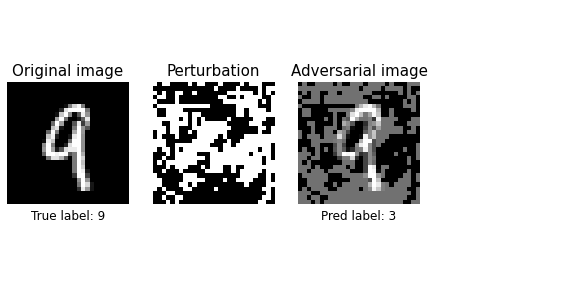

<Figure size 1440x144 with 0 Axes>

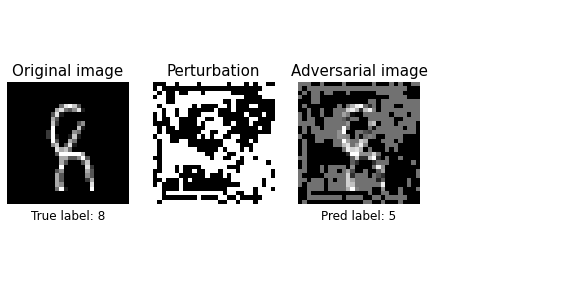

<Figure size 1440x144 with 0 Axes>

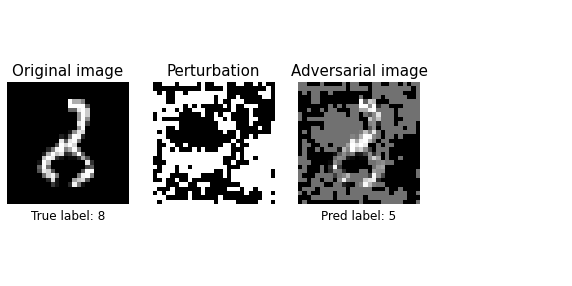

<Figure size 1440x144 with 0 Axes>

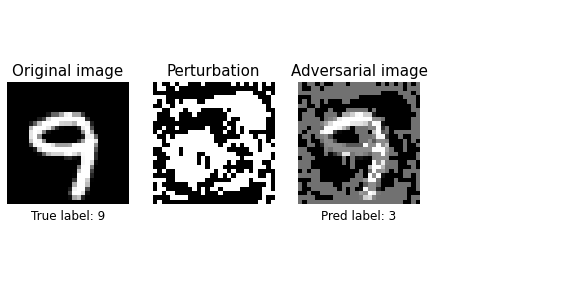

<Figure size 1440x144 with 0 Axes>

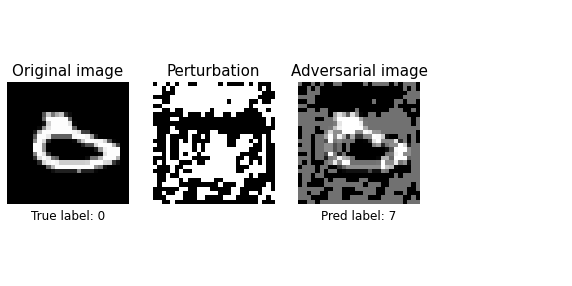

<Figure size 1440x144 with 0 Axes>

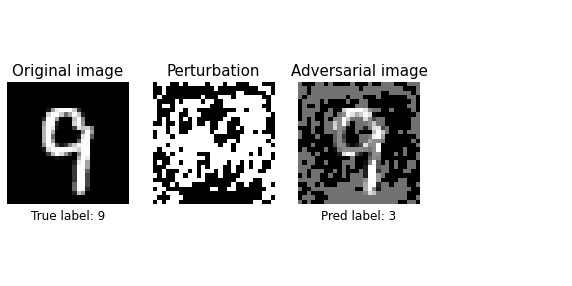

<Figure size 1440x144 with 0 Axes>

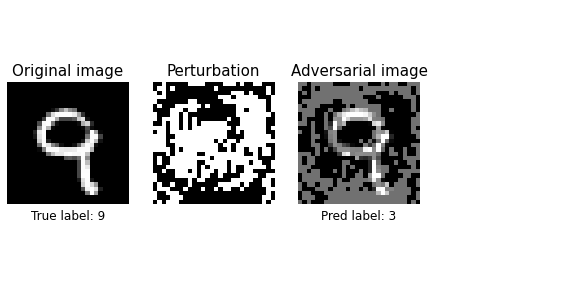

<Figure size 1440x144 with 0 Axes>

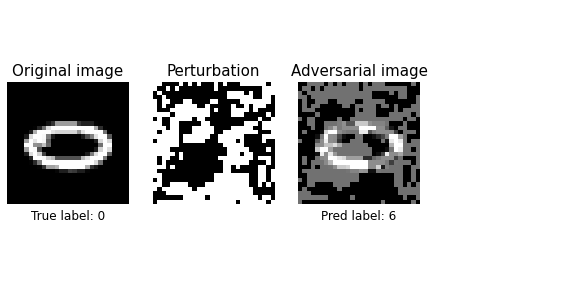

<Figure size 1440x144 with 0 Axes>

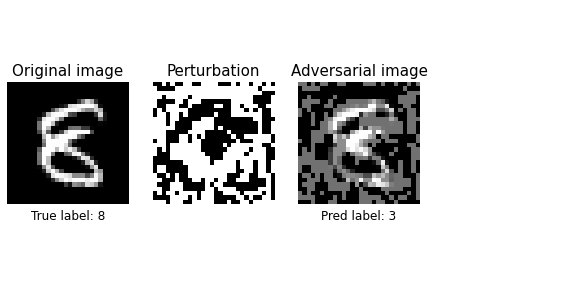

<Figure size 1440x144 with 0 Axes>

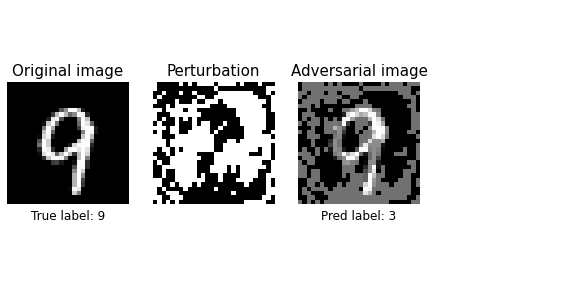

<Figure size 1440x144 with 0 Axes>

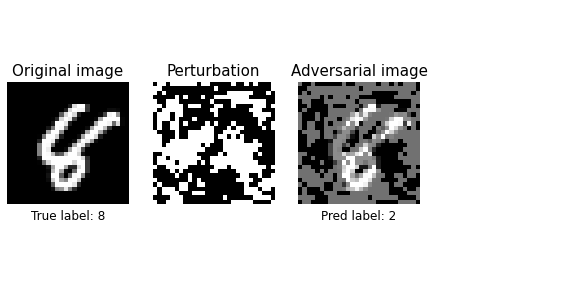

<Figure size 1440x144 with 0 Axes>

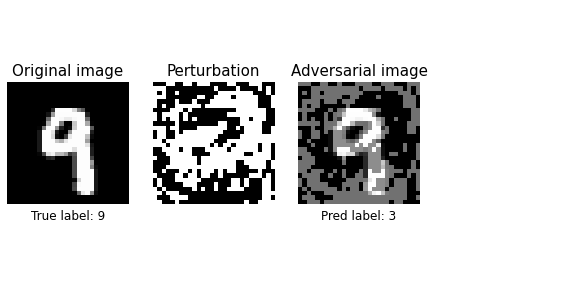

<Figure size 1440x144 with 0 Axes>

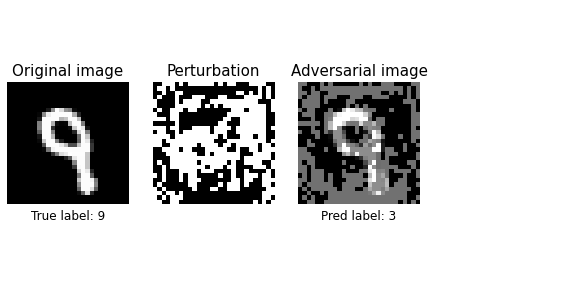

<Figure size 1440x144 with 0 Axes>

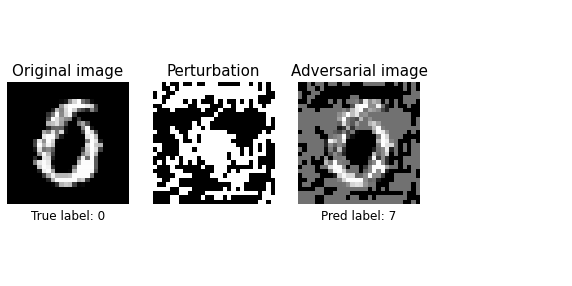

<Figure size 1440x144 with 0 Axes>

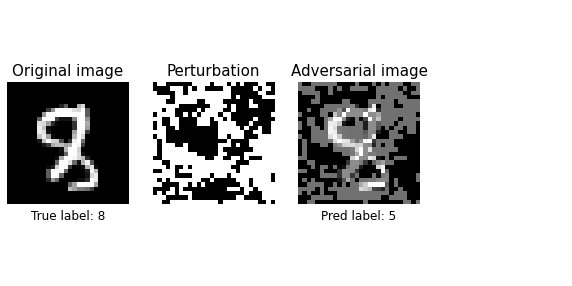

<Figure size 1440x144 with 0 Axes>

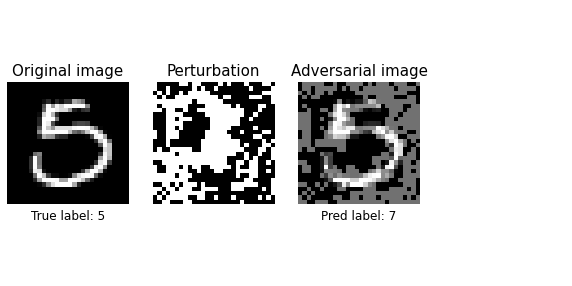

<Figure size 1440x144 with 0 Axes>

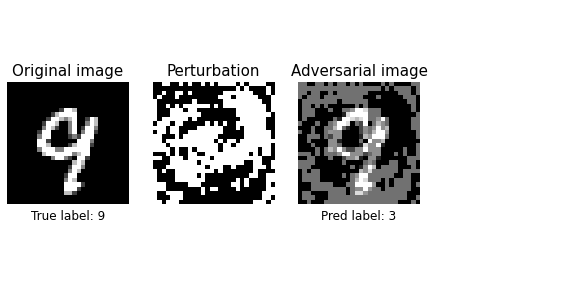

<Figure size 1440x144 with 0 Axes>

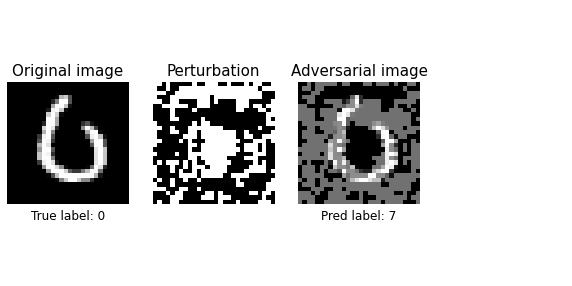

<Figure size 1440x144 with 0 Axes>

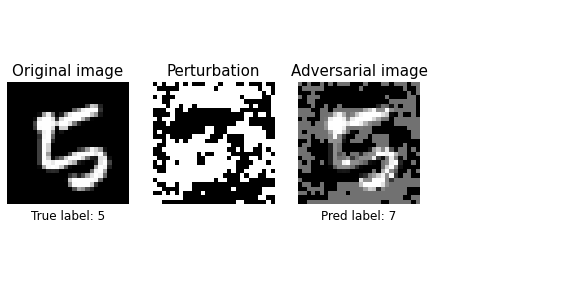

<Figure size 1440x144 with 0 Axes>

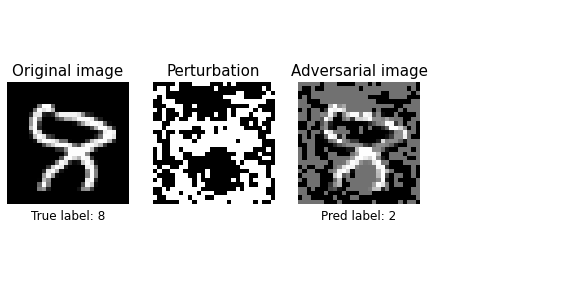

<Figure size 1440x144 with 0 Axes>

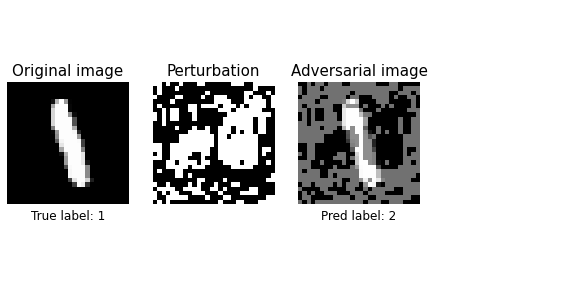

<Figure size 1440x144 with 0 Axes>

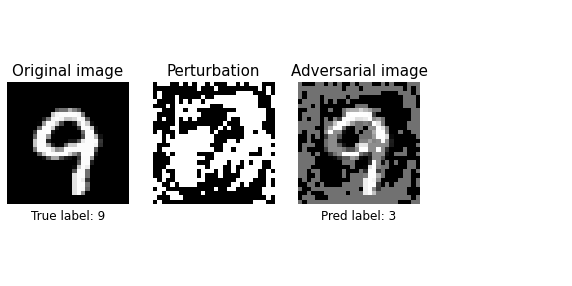

<Figure size 1440x144 with 0 Axes>

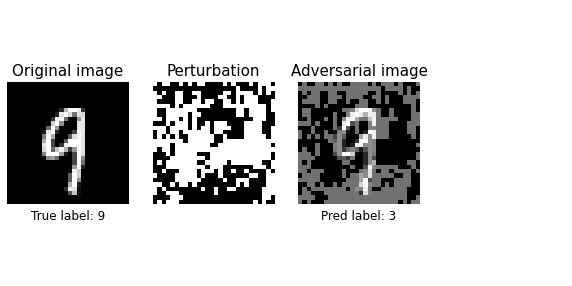

<Figure size 1440x144 with 0 Axes>

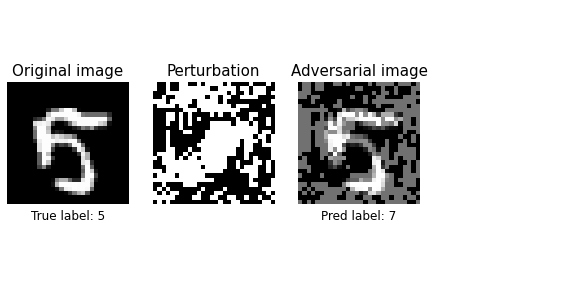

<Figure size 1440x144 with 0 Axes>

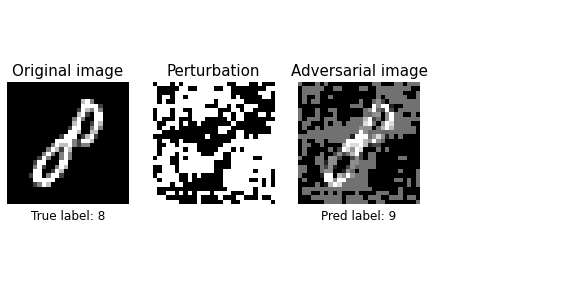

<Figure size 1440x144 with 0 Axes>

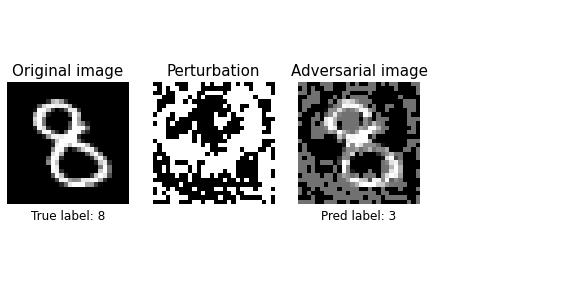

<Figure size 1440x144 with 0 Axes>

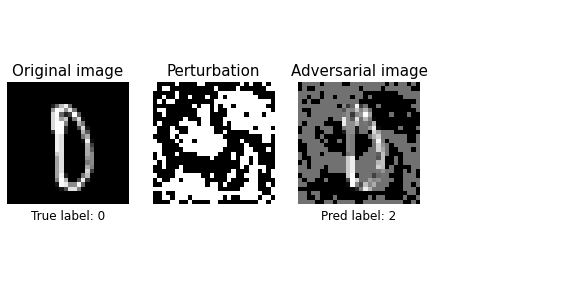

<Figure size 1440x144 with 0 Axes>

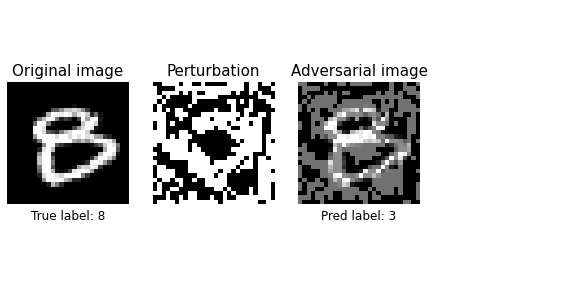

<Figure size 1440x144 with 0 Axes>

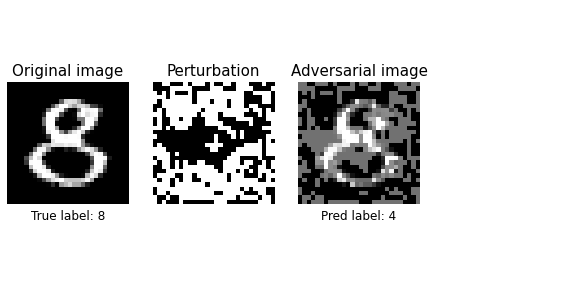

<Figure size 1440x144 with 0 Axes>

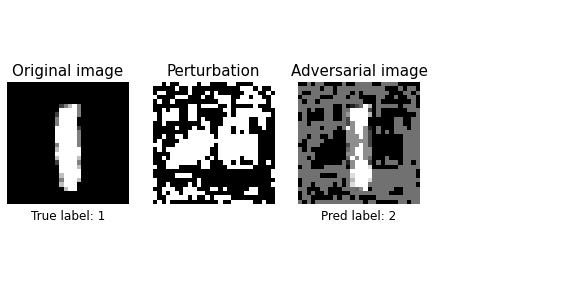

<Figure size 1440x144 with 0 Axes>

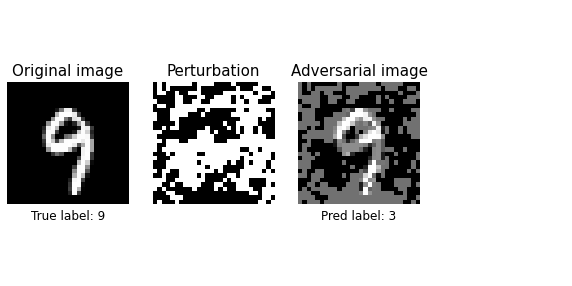

<Figure size 1440x144 with 0 Axes>

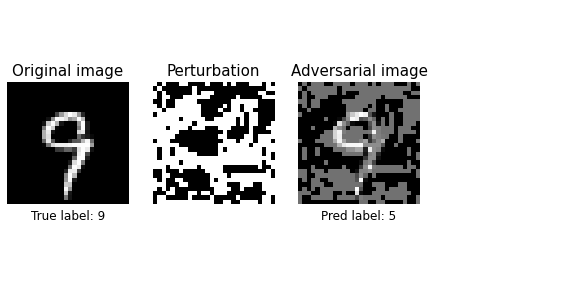

<Figure size 1440x144 with 0 Axes>

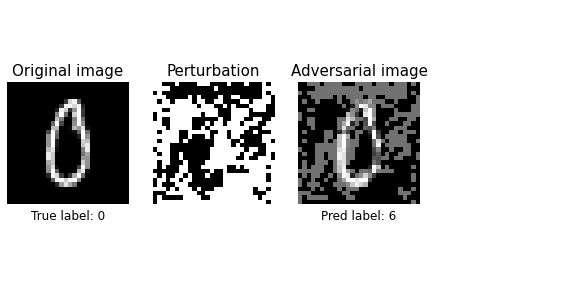

<Figure size 1440x144 with 0 Axes>

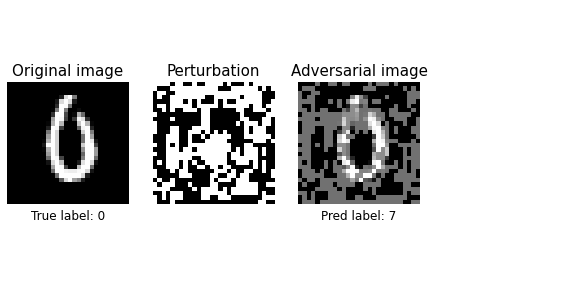

<Figure size 1440x144 with 0 Axes>

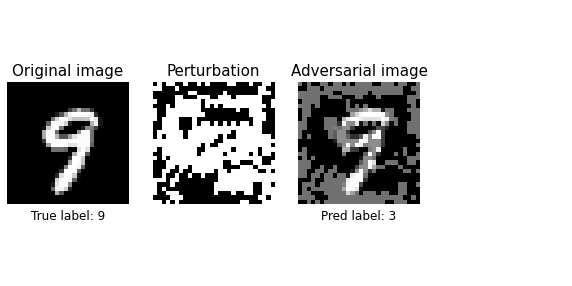

<Figure size 1440x144 with 0 Axes>

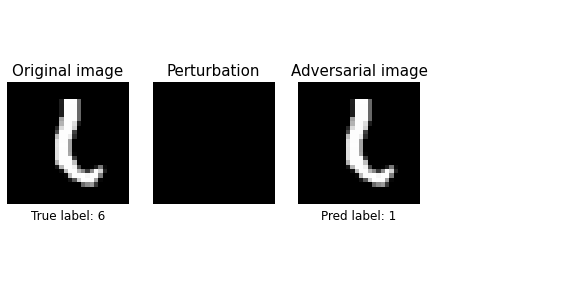

<Figure size 1440x144 with 0 Axes>

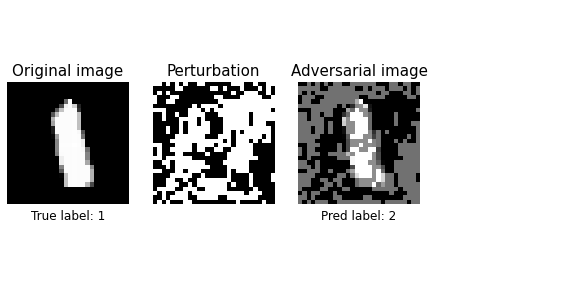

<Figure size 1440x144 with 0 Axes>

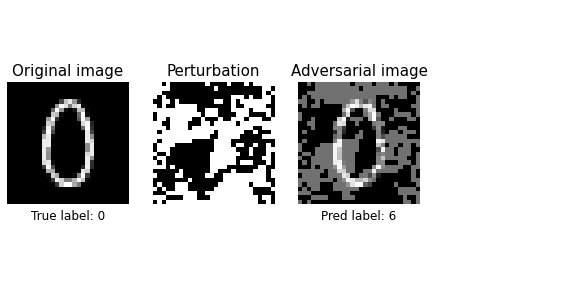

<Figure size 1440x144 with 0 Axes>

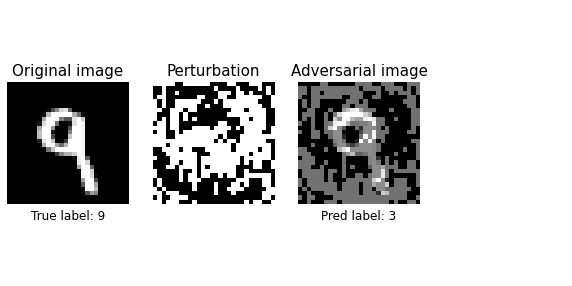

<Figure size 1440x144 with 0 Axes>

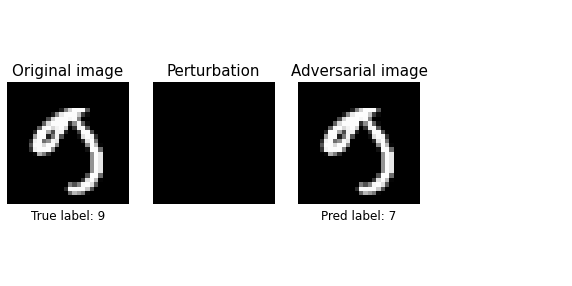

<Figure size 1440x144 with 0 Axes>

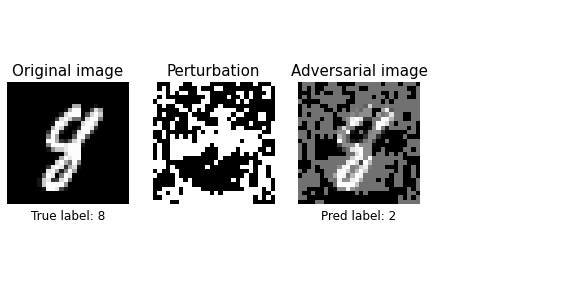

<Figure size 1440x144 with 0 Axes>

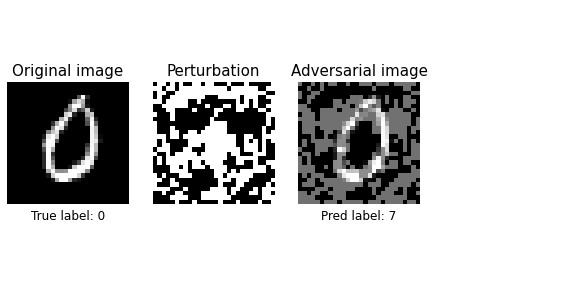

<Figure size 1440x144 with 0 Axes>

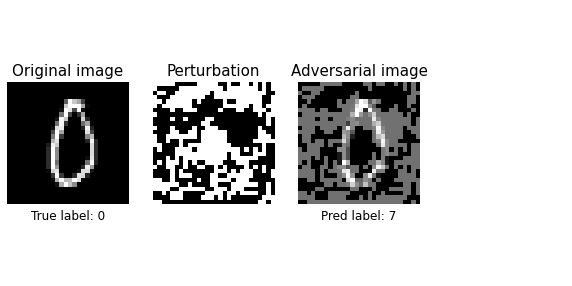

<Figure size 1440x144 with 0 Axes>

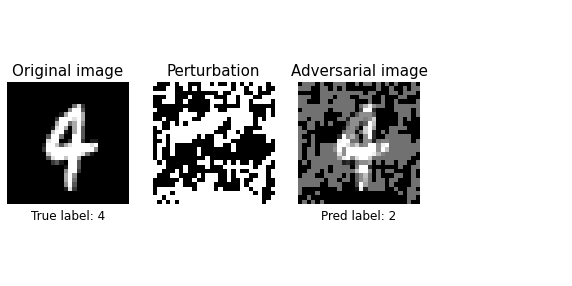

<Figure size 1440x144 with 0 Axes>

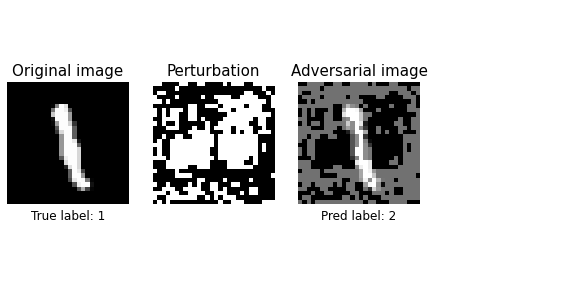

<Figure size 1440x144 with 0 Axes>

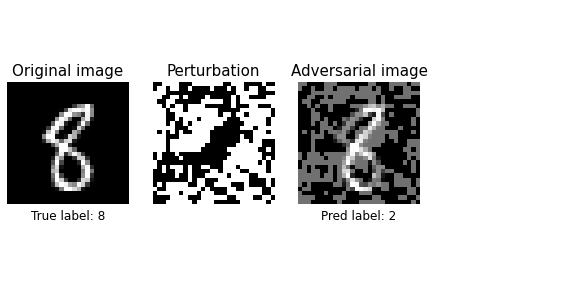

<Figure size 1440x144 with 0 Axes>

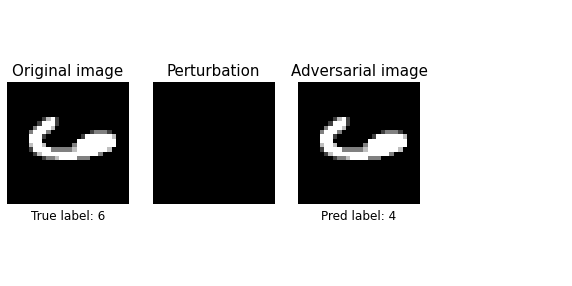

<Figure size 1440x144 with 0 Axes>

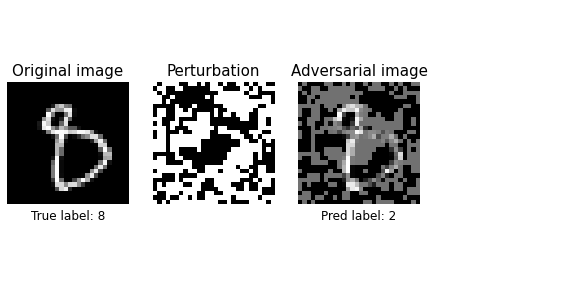

<Figure size 1440x144 with 0 Axes>

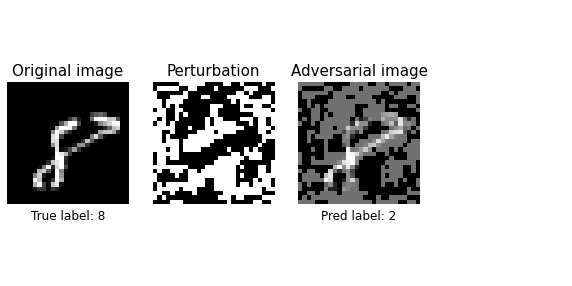

<Figure size 1440x144 with 0 Axes>

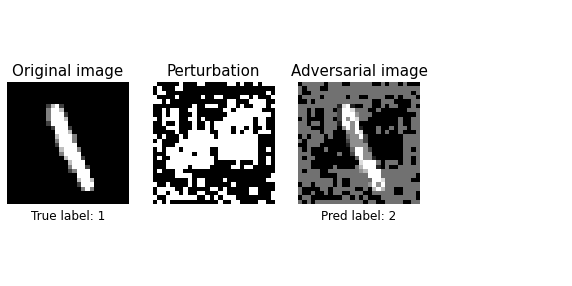

<Figure size 1440x144 with 0 Axes>

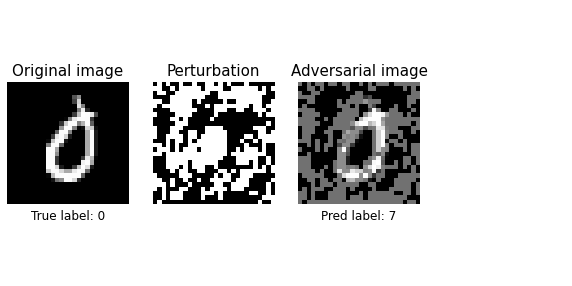

<Figure size 1440x144 with 0 Axes>

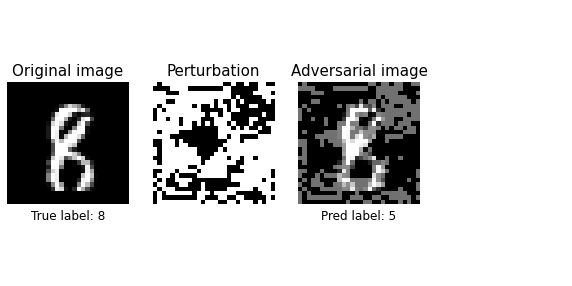

<Figure size 1440x144 with 0 Axes>

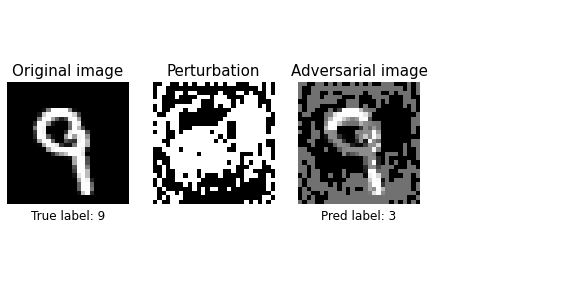

<Figure size 1440x144 with 0 Axes>

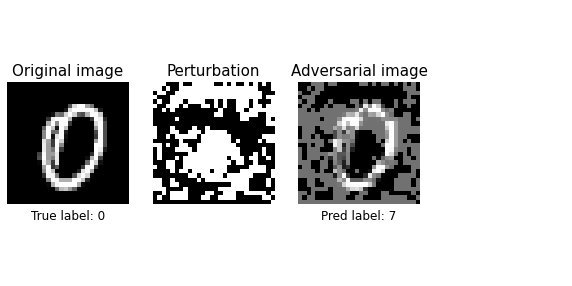

<Figure size 1440x144 with 0 Axes>

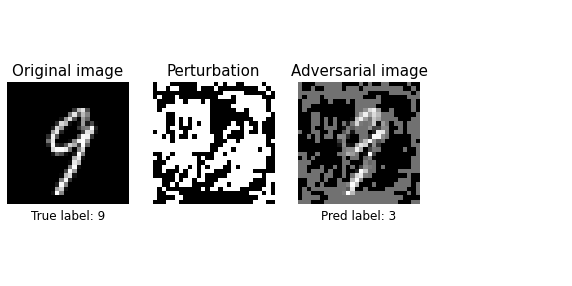

<Figure size 1440x144 with 0 Axes>

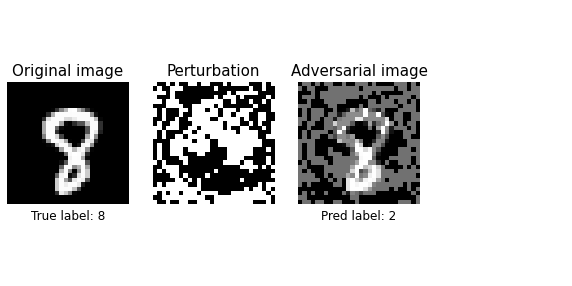

<Figure size 1440x144 with 0 Axes>

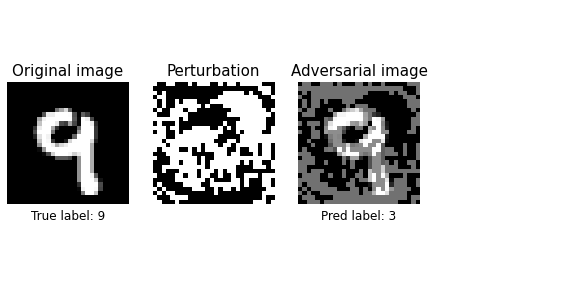

<Figure size 1440x144 with 0 Axes>

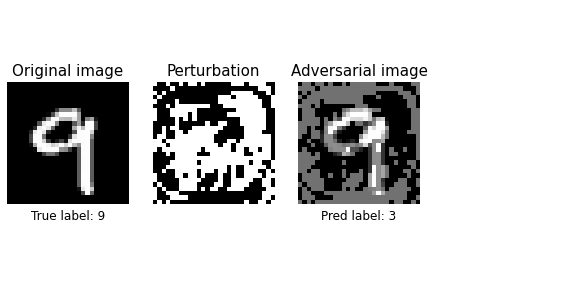

<Figure size 1440x144 with 0 Axes>

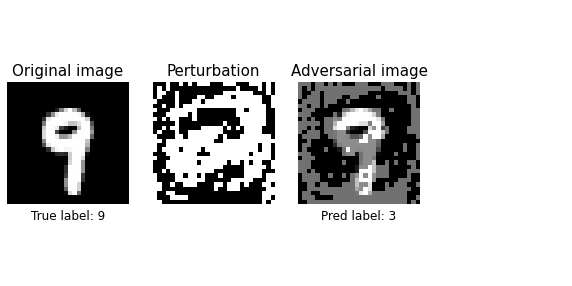

<Figure size 1440x144 with 0 Axes>

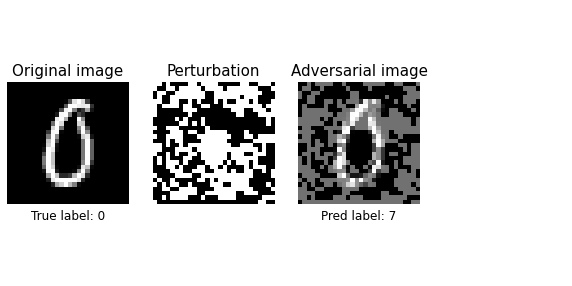

<Figure size 1440x144 with 0 Axes>

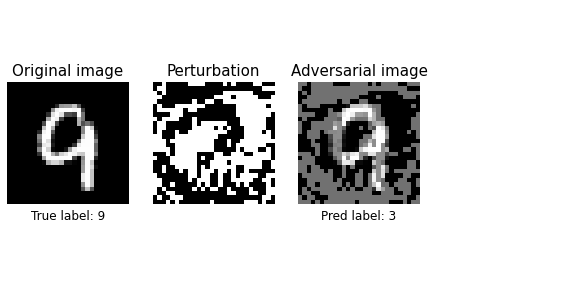

<Figure size 1440x144 with 0 Axes>

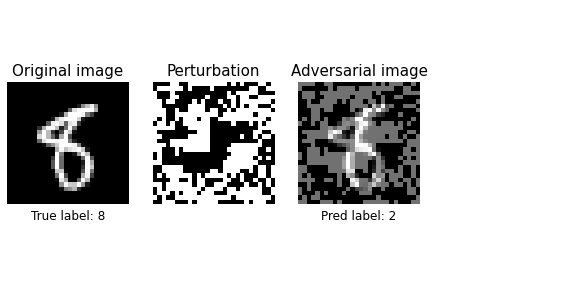

<Figure size 1440x144 with 0 Axes>

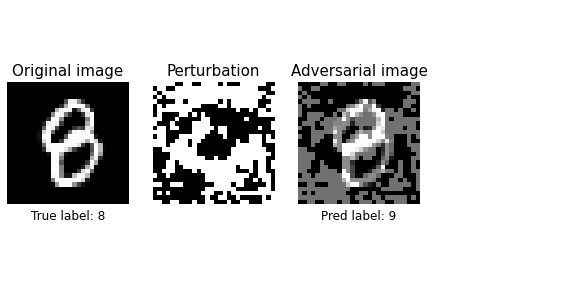

<Figure size 1440x144 with 0 Axes>

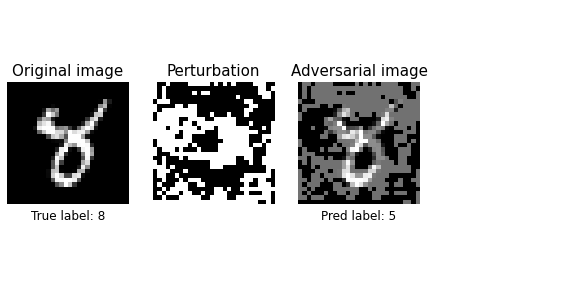

<Figure size 1440x144 with 0 Axes>

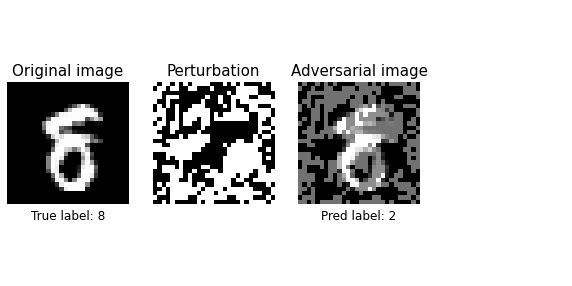

<Figure size 1440x144 with 0 Axes>

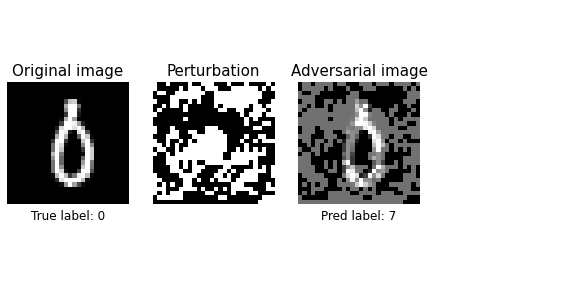

<Figure size 1440x144 with 0 Axes>

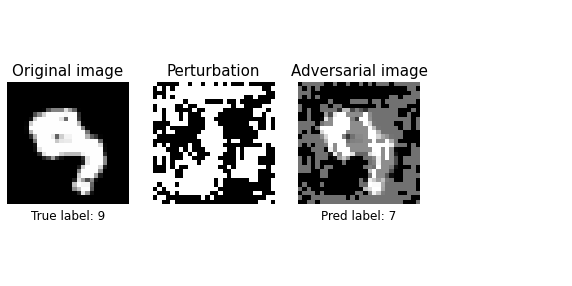

<Figure size 1440x144 with 0 Axes>

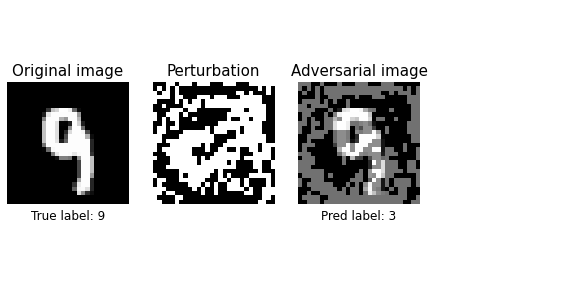

<Figure size 1440x144 with 0 Axes>

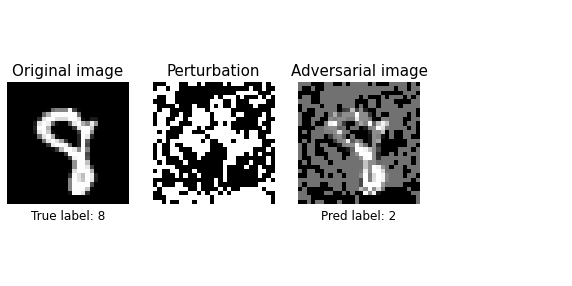

<Figure size 1440x144 with 0 Axes>

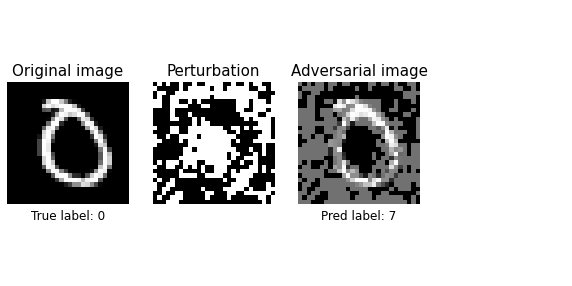

<Figure size 1440x144 with 0 Axes>

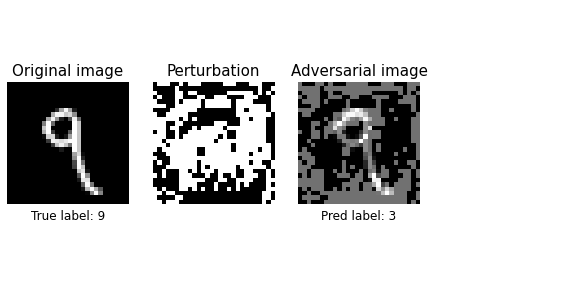

<Figure size 1440x144 with 0 Axes>

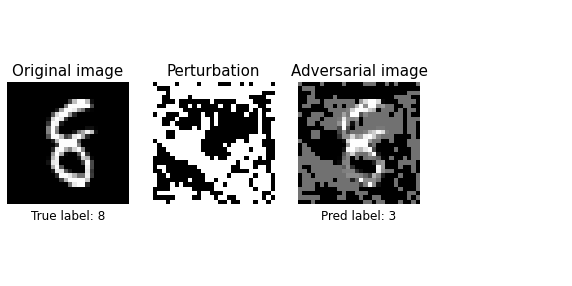

<Figure size 1440x144 with 0 Axes>

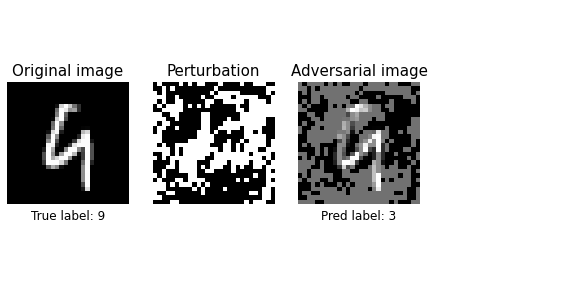

<Figure size 1440x144 with 0 Axes>

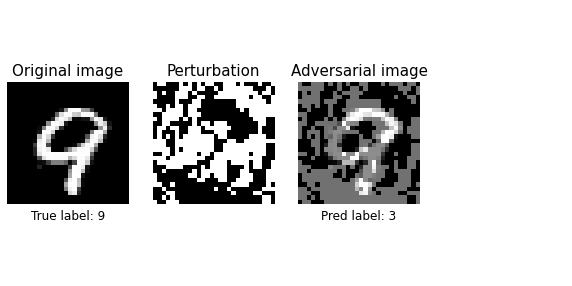

<Figure size 1440x144 with 0 Axes>

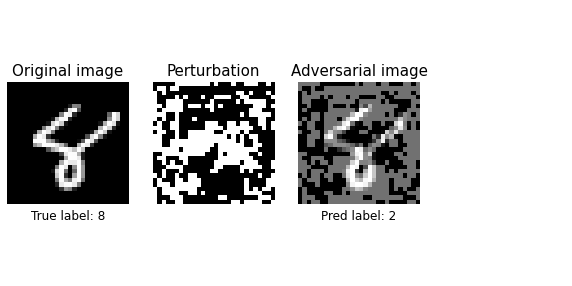

<Figure size 1440x144 with 0 Axes>

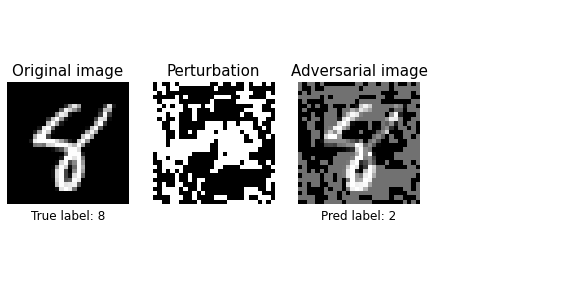

<Figure size 1440x144 with 0 Axes>

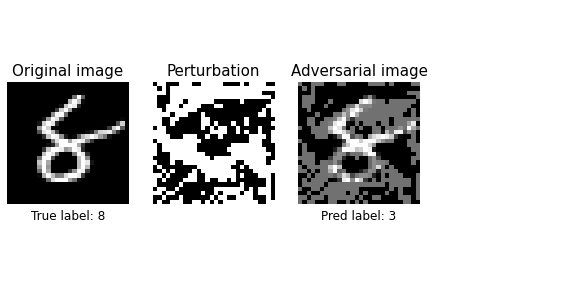

<Figure size 1440x144 with 0 Axes>

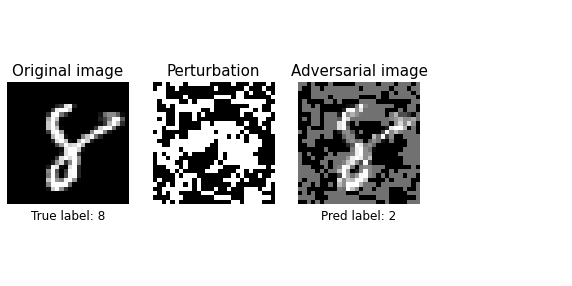

<Figure size 1440x144 with 0 Axes>

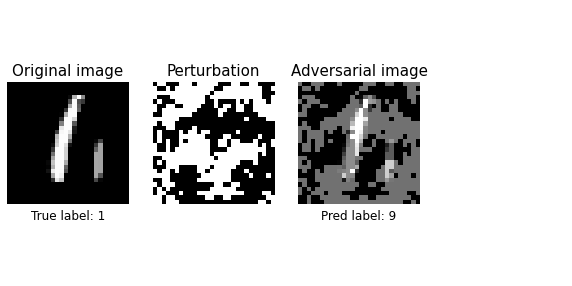

<Figure size 1440x144 with 0 Axes>

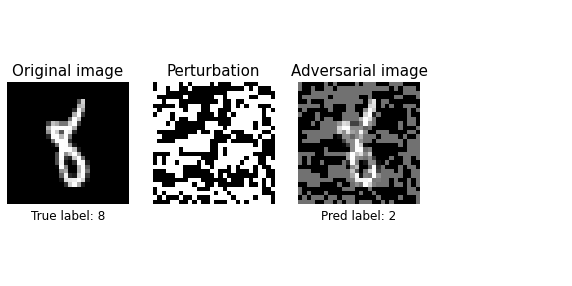

<Figure size 1440x144 with 0 Axes>

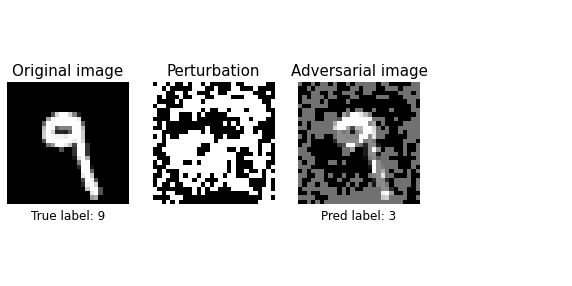

<Figure size 1440x144 with 0 Axes>

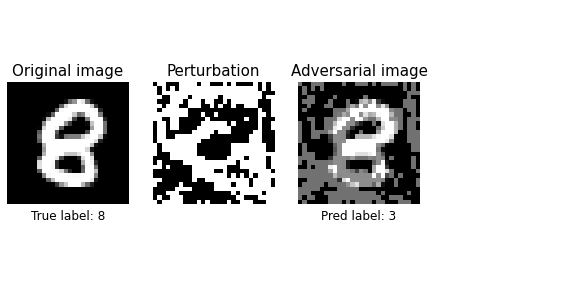

<Figure size 1440x144 with 0 Axes>

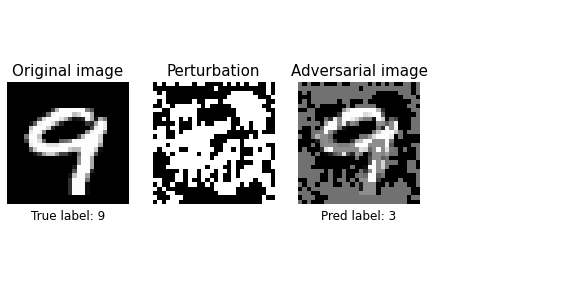

<Figure size 1440x144 with 0 Axes>

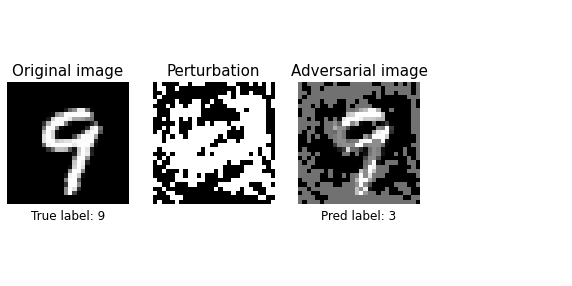

<Figure size 1440x144 with 0 Axes>

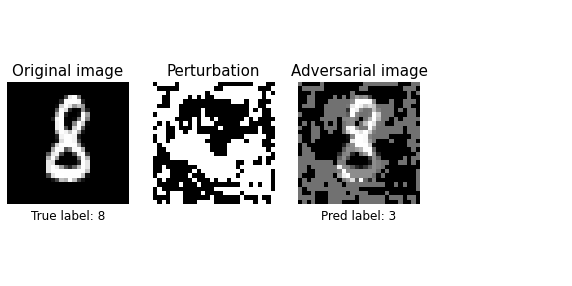

<Figure size 1440x144 with 0 Axes>

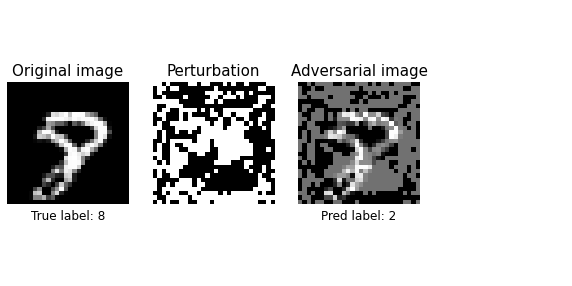

<Figure size 1440x144 with 0 Axes>

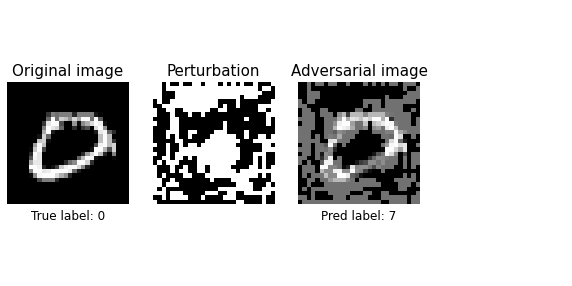

<Figure size 1440x144 with 0 Axes>

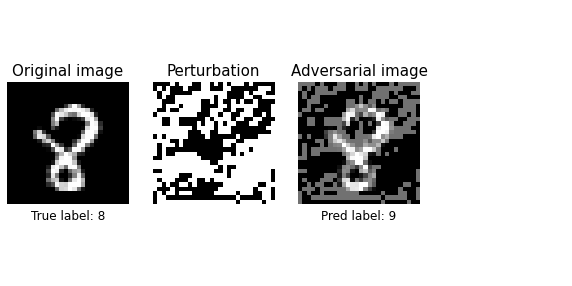

<Figure size 1440x144 with 0 Axes>

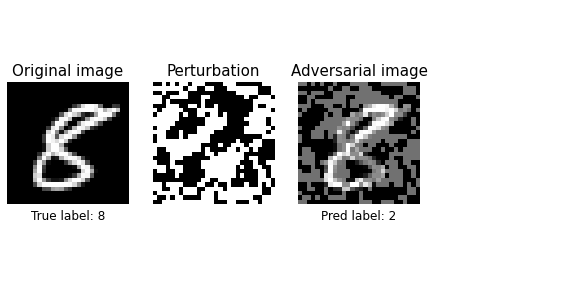

<Figure size 1440x144 with 0 Axes>

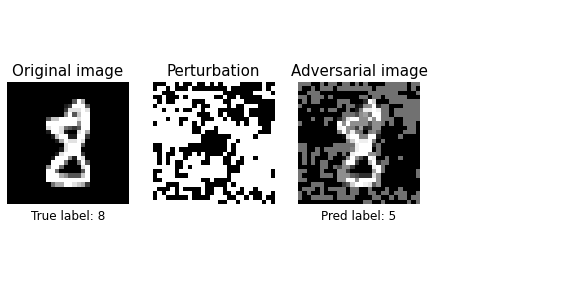

<Figure size 1440x144 with 0 Axes>

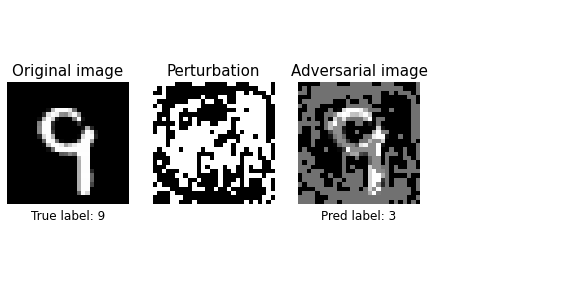

<Figure size 1440x144 with 0 Axes>

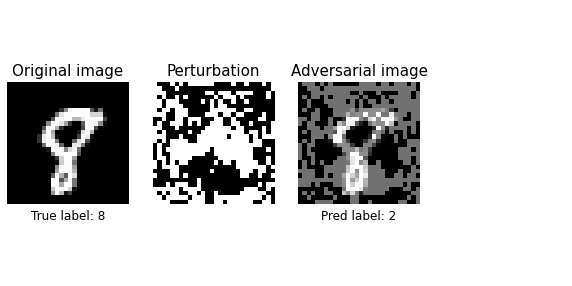

<Figure size 1440x144 with 0 Axes>

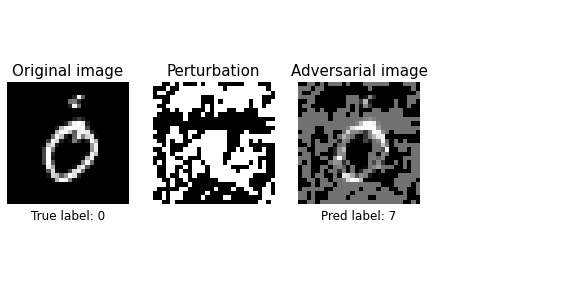

<Figure size 1440x144 with 0 Axes>

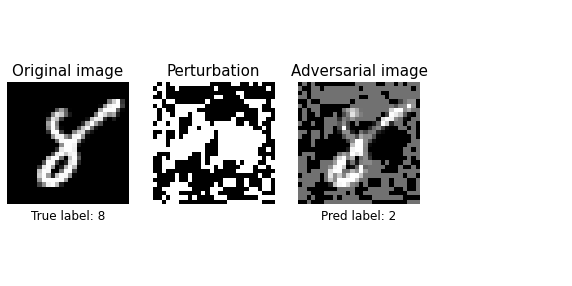

<Figure size 1440x144 with 0 Axes>

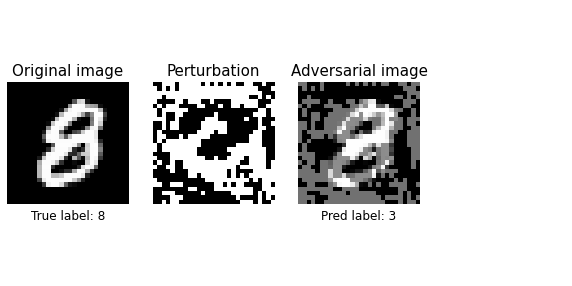

<Figure size 1440x144 with 0 Axes>

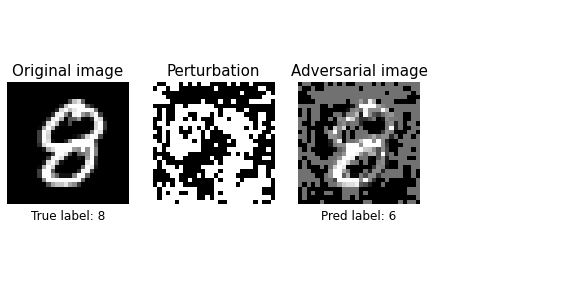

<Figure size 1440x144 with 0 Axes>

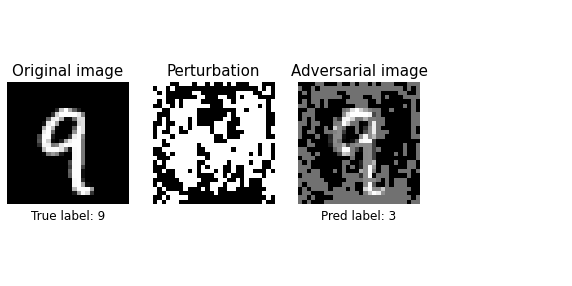

<Figure size 1440x144 with 0 Axes>

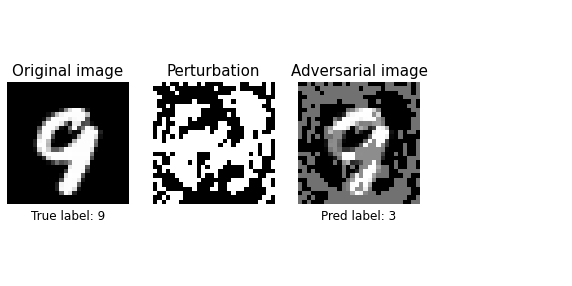

<Figure size 1440x144 with 0 Axes>

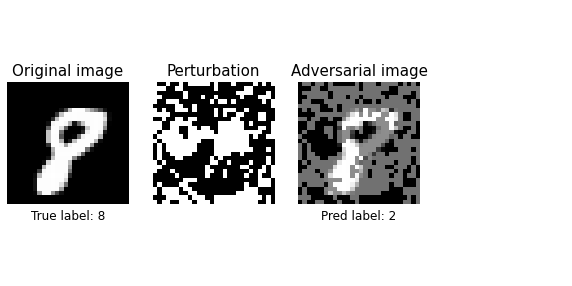

<Figure size 1440x144 with 0 Axes>

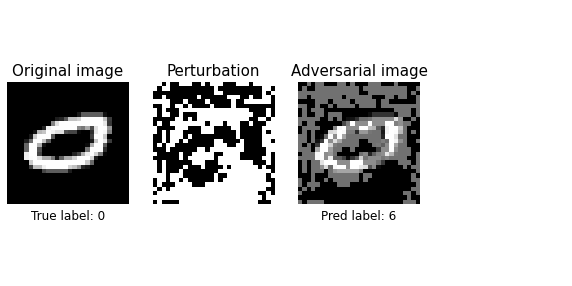

<Figure size 1440x144 with 0 Axes>

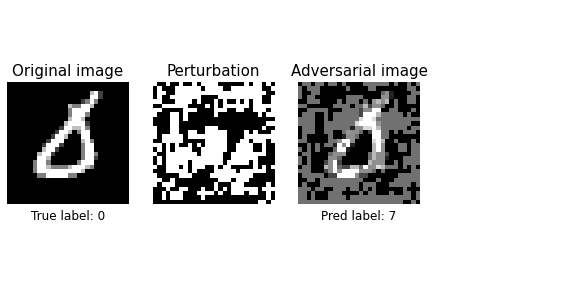

<Figure size 1440x144 with 0 Axes>

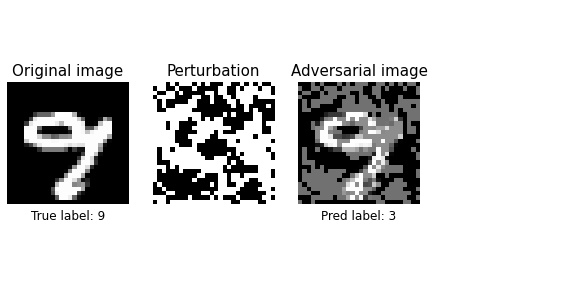

<Figure size 1440x144 with 0 Axes>

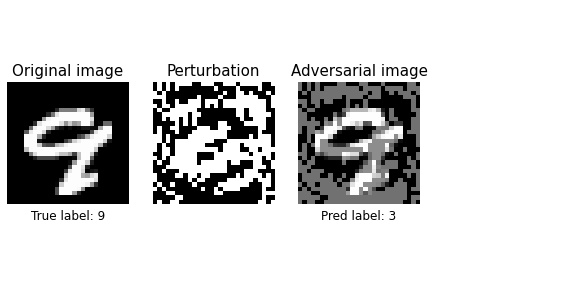

<Figure size 1440x144 with 0 Axes>

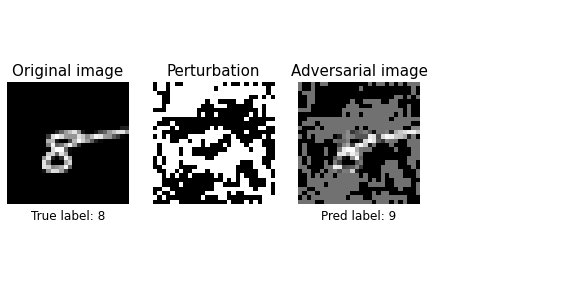

<Figure size 1440x144 with 0 Axes>

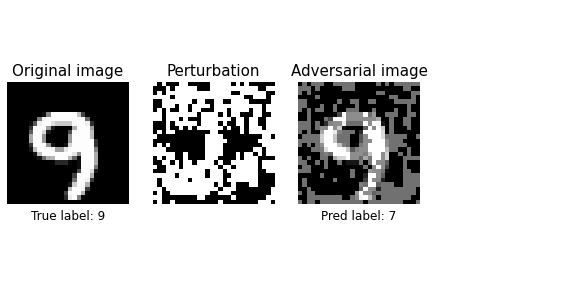

<Figure size 1440x144 with 0 Axes>

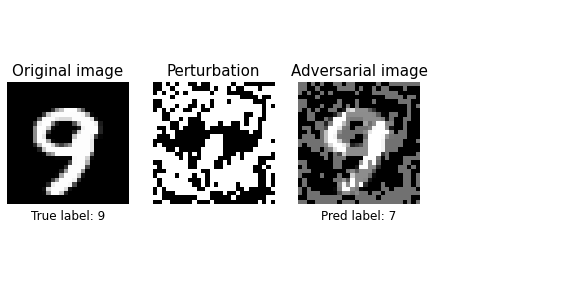

<Figure size 1440x144 with 0 Axes>

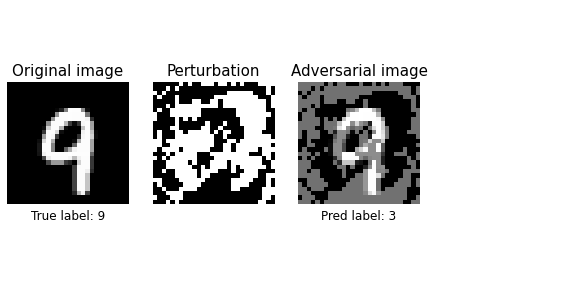

<Figure size 1440x144 with 0 Axes>

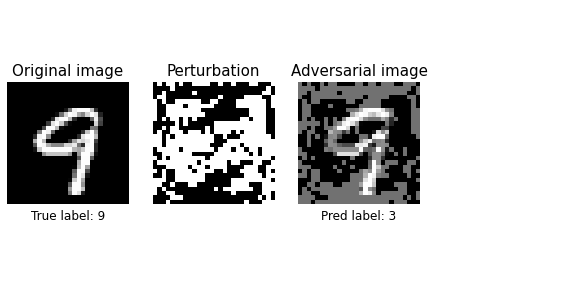

<Figure size 1440x144 with 0 Axes>

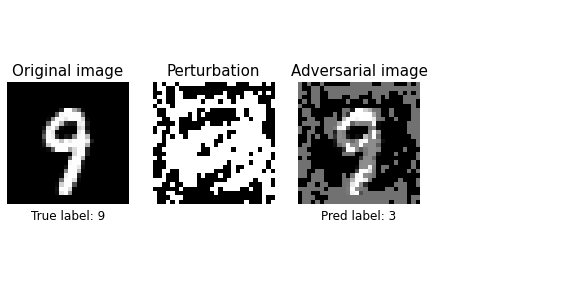

<Figure size 1440x144 with 0 Axes>

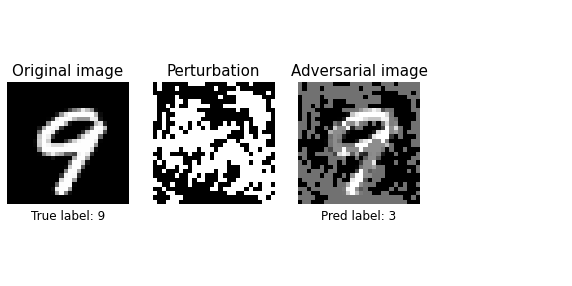

<Figure size 1440x144 with 0 Axes>

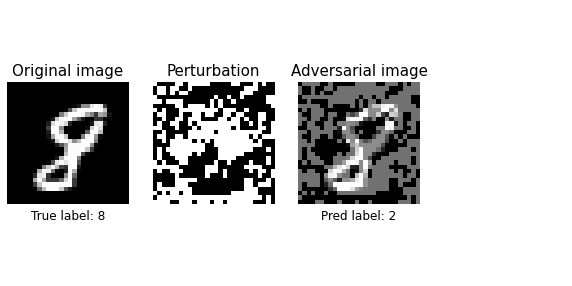

<Figure size 1440x144 with 0 Axes>

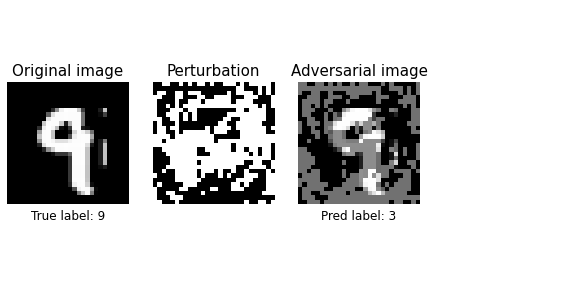

<Figure size 1440x144 with 0 Axes>

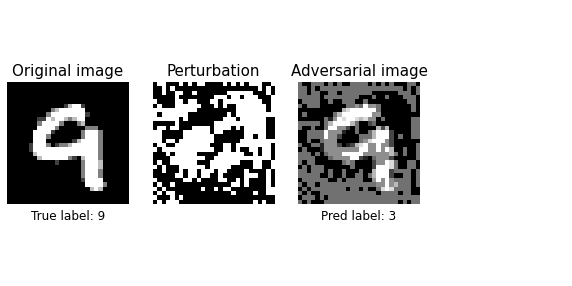

<Figure size 1440x144 with 0 Axes>

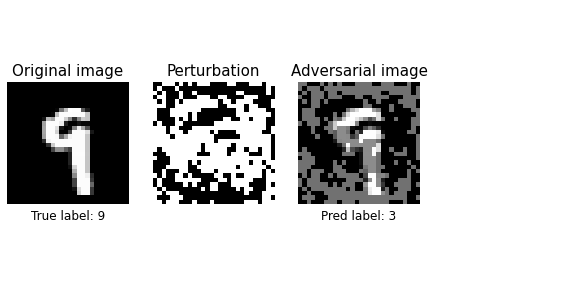

<Figure size 1440x144 with 0 Axes>

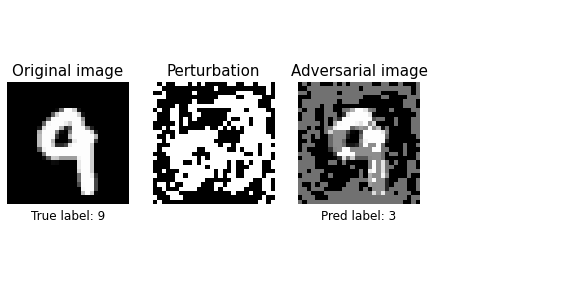

<Figure size 1440x144 with 0 Axes>

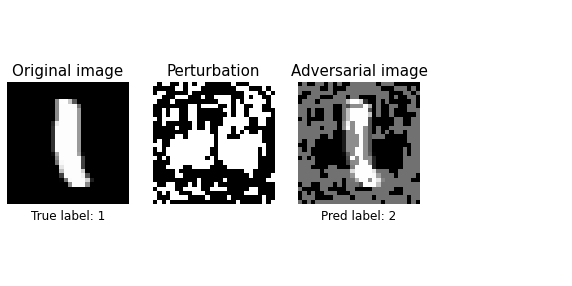

<Figure size 1440x144 with 0 Axes>

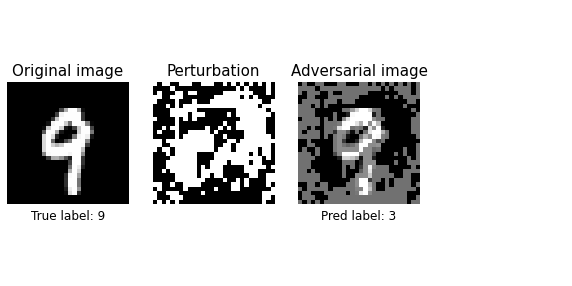

<Figure size 1440x144 with 0 Axes>

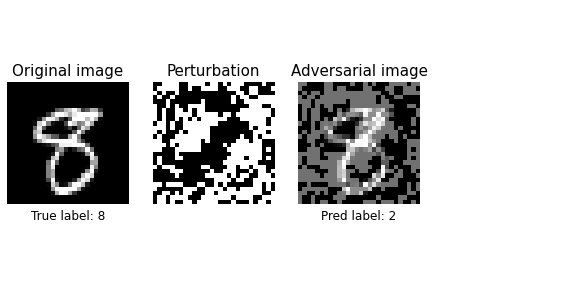

<Figure size 1440x144 with 0 Axes>

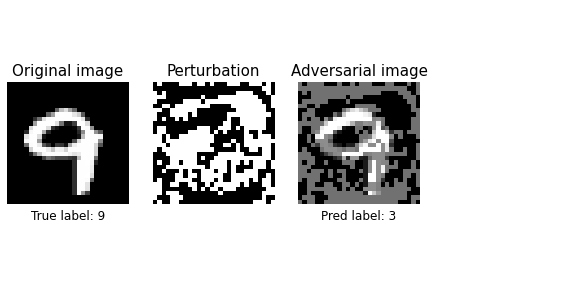

<Figure size 1440x144 with 0 Axes>

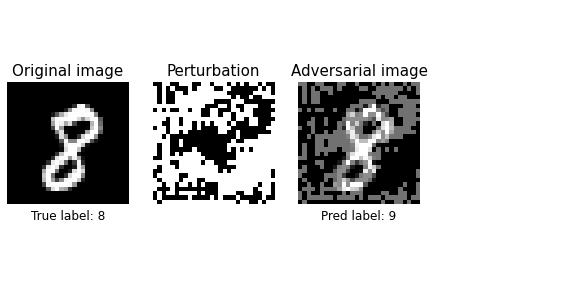

<Figure size 1440x144 with 0 Axes>

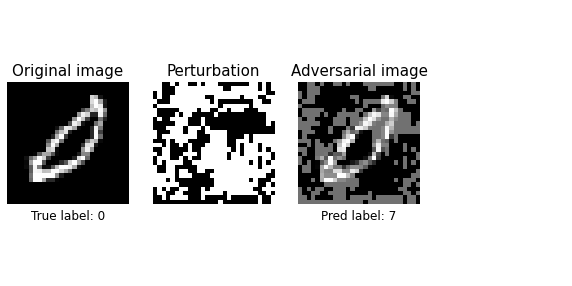

<Figure size 1440x144 with 0 Axes>

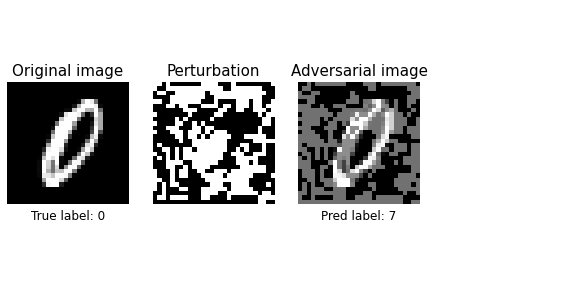

In [99]:
for idx in x_x_adv_imgs_bim2:
    display_one_pair(x_test[idx], x_test_bim_imgs2[idx], x_test_bim_perts2[idx], y_test[idx], test_bim_preds2[idx])

## Dense Autoencoder

In [86]:
(x_train_dense, y_train_dense), (x_test_dense, y_test_dense) = mnist.load_data(mnist_path)

ERROR! Session/line number was not unique in database. History logging moved to new session 661


In [87]:
x_train_dense.shape, y_train_dense.shape

((60000, 28, 28), (60000,))

In [88]:
x_train_dense = x_train_dense.astype('float32')/255.0
x_test_dense = x_test_dense.astype('float32')/255.0

x_train_dense = x_train_dense.reshape((len(x_train_dense), np.prod(x_train_dense.shape[1:])))
x_test_dense = x_test_dense.reshape((len(x_test_dense), np.prod(x_test_dense.shape[1:])))
x_train_dense.shape, y_train_dense.shape

((60000, 784), (60000,))

In [266]:
input_shape_dense=x_train_dense[0].shape

In [267]:
model_autoencoder_basic = Sequential([
    #encoder
    Dense(256, activation = 'relu', input_shape=input_shape_dense),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    
    #decoder
    Dense(128, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(28*28, activation = 'sigmoid')
])
model_autoencoder_basic.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 784)               201488    
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0
________________________________________________

In [92]:
model_autoencoder_basic.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [93]:
model_autoencoder_basic.fit(x_train_dense, x_train_dense, 
                           epochs=n_epochs,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           validation_data=(x_test_dense,x_test_dense))

ERROR! Session/line number was not unique in database. History logging moved to new session 519
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0203 - mae: 0.0557 - val_loss: 0.0151 - val_mae: 0.0447
Epoch 2/30
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0136 - mae: 0.0415 - val_loss: 0.0118 - val_mae: 0.0377
Epoch 3/30
60000/60000 [==============================] - 5s 89us/sample - loss: 0.0111 - mae: 0.0361 - val_loss: 0.0100 - val_mae: 0.0337
Epoch 4/30
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0097 - mae: 0.0331 - val_loss: 0.0089 - val_mae: 0.0310
Epoch 5/30
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0088 - mae: 0.0309 - val_loss: 0.0083 - val_mae: 0.0295
Epoch 6/30
60000/60000 [==============================] - 5s 85us/sample - loss: 0.0081 - mae: 0.0293 - val_loss: 0.0077 - val_mae: 0.0285
Epoch 7/30
60000/600

In [89]:
#load model
model_autoencoder_basic = tf.keras.models.load_model(os.path.join('saved_models','dense_autoencoder_256-128-64.h5'))
model_autoencoder_basic.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 662
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
Total params: 484,944
Trai

In [270]:
#dense_pred_imgs = model_autoencoder_basic.predict(x_test_dense)
dense_pred_imgs = model_autoencoder_basic.predict(x_test_dense)

In [91]:
#display pair of images: Original and Autoencoder restored images
def display_pair2(x1, x2, autoenc_name='', n=10):
    #indices = np.random.randint(len(x1), size=n)
    indices = np.arange(0,10,1)
    imgs_1 = x1[indices, :]
    imgs_2 = x2[indices, :] 
    
    
   # plt.text(1.0, 0.5, title, fontsize=30, visible=True)   
    fig = plt.figure(figsize=(20,4))
    for i, img1 in enumerate(imgs_1):
        ax = plt.subplot(2, n, i+1) #nrows, ncols, cur_col
        plt.imshow(img1.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.suptitle('Original images',y=1.0,fontsize=20)     
    
    fig2 = plt.figure(figsize=(20,4))
    for i,  img2 in enumerate(imgs_2):
        ax=plt.subplot(2, n, i+1+n)
        plt.imshow(img2.reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig2.suptitle(f'Restored images with {autoenc_name} autoenc',y=0.6, fontsize=20)
    
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 663


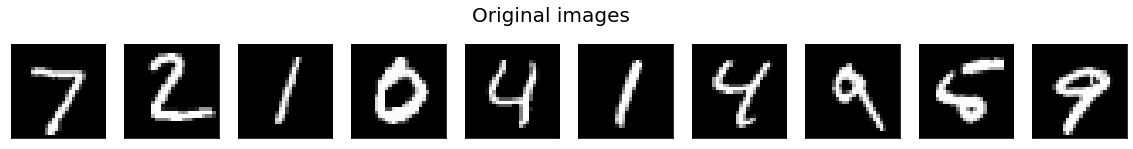

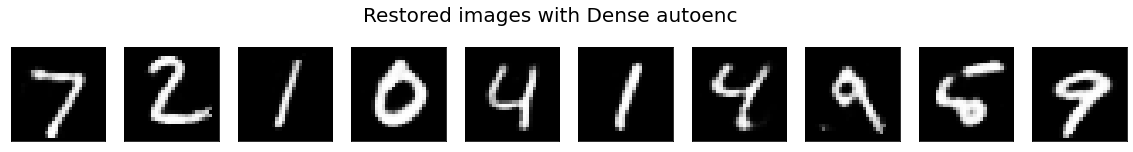

In [337]:
display_pair2(x_test_dense, dense_pred_imgs,'Dense')

In [273]:
autoenc_eval = model_autoencoder_basic.evaluate(x_test_dense,x_test_dense)
autoenc_eval

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.004060318141430617, 0.019884303]

In [90]:
# fgsm
x_test_fgsm_imgs_reshape2 = x_test_fgsm_imgs2.reshape(len(x_test_fgsm_imgs2), np.prod(x_train_dense.shape[1:]))
print(x_test_fgsm_imgs_reshape2.shape)
#try to clean images after fgsm perturbation
clean_fgsm_img_dense_autoenc2 = model_autoencoder_basic.predict(x_test_fgsm_imgs_reshape2)
clean_fgsm_img_dense_autoenc2[0].shape

(10000, 784)


(784,)

In [325]:
# onesteplesslikely
x_test_onest_imgs_reshape2 = x_test_onest_imgs2.reshape(len(x_test_onest_imgs2), np.prod(x_train_dense.shape[1:]))
print(x_test_onest_imgs_reshape2.shape)
clean_onest_img_dense_autoenc2 = model_autoencoder_basic.predict(x_test_onest_imgs_reshape2)
clean_onest_img_dense_autoenc2[0].shape


(10000, 784)


(784,)

In [100]:
# bim
x_test_bim_imgs_reshape2 = x_test_bim_imgs2.reshape(len(x_test_bim_imgs2), np.prod(x_train_dense.shape[1:]))
print(x_test_bim_imgs_reshape2.shape)
clean_bim_img_dense_autoenc2 = model_autoencoder_basic.predict(x_test_bim_imgs_reshape2)
clean_bim_img_dense_autoenc2[0].shape

(10000, 784)
ERROR! Session/line number was not unique in database. History logging moved to new session 669


(784,)

In [278]:
# fgvm
x_test_fgvm_imgs_reshape2 = x_test_fgvm_imgs2.reshape(len(x_test_fgvm_imgs2), np.prod(x_train_dense.shape[1:]))
print(x_test_fgvm_imgs_reshape2.shape)
clean_fgvm_img_dense_autoenc2 = model_autoencoder_basic.predict(x_test_fgvm_imgs_reshape2)
clean_fgvm_img_dense_autoenc2[0].shape

(10000, 784)


(784,)

## Conv Autoencoder

In [102]:
#AUTOENCODER

input_img = Input(shape=x_train[0].shape)

#Encoder
x=Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_img)
x=MaxPooling2D(pool_size=(2,2), padding='same')(x)
x=Conv2D(16, (3,3), activation='relu', padding='same')(x)

encoded=MaxPooling2D((2,2), padding='same')(x)

#Decoder
x=Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x=UpSampling2D((2,2))(x)
x=Conv2D(16, (3,3), activation='relu', padding='same')(x)
x=UpSampling2D((2,2))(x)

decoded=Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

In [103]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optmizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0     

In [ ]:
autoencoder.fit(x_train, x_train, 
               epochs=n_epochs,
               batch_size=BATCH_SIZE,
               shuffle=True,
               validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30


60000/60000 [==============================] - 83s 1ms/sample - loss: 0.1379 - val_loss: 0.1037
Epoch 2/30
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0927 - val_loss: 0.0880
Epoch 3/30
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0859 - val_loss: 0.0808
Epoch 4/30
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.0822 - val_loss: 0.0805
Epoch 5/30
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0800 - val_loss: 0.0782
Epoch 6/30
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.0785 - val_loss: 0.0771
Epoch 7/30
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.0773 - val_loss: 0.0765
Epoch 8/30
51072/60000 [========================>.....] - ETA: 12s - loss: 0.0765

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-104-6ac2059682f6>", line 5, in <module>
    validation_data=(x_test,x_test))
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 123, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py", line 86, in execution_function


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-104-6ac2059682f6>", line 5, in <module>
    validation_data=(x_test,x_test))
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 123, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "/home/anaconda3/envs/flags_tf/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2_utils.py", line 86, in execution_function


In [ ]:
# if save_model==True:
#     autoencoder.save(os.path.join(save_path, 'autoenc_clean_clean'))
#     autoencoder.save(os.path.join(save_path, 'autoenc_clean_clean.h5'))

In [105]:
autoencoder = tf.keras.models.load_model(os.path.join('saved_models', 'autoenc_clean_clean.h5'))
autoencoder.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 521
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_______________________________

In [106]:
autoenc_preds = autoencoder.predict(x_test)

## EVALUATE DEFAULT MODEL BEFORE AND AFTER NOISING/ATTACK

In [107]:
# loaded_model_mnist = tf.keras.models.load_model(os.path.join(save_path, 'mnist_default_model.h5'))
# default_score = loaded_model_mnist.evaluate(x_test,y_test)
print(f'Default model score:\nloss: {default_score_2[0]} mae: {default_score_2[1]} accuracy: {default_score_2[2]}')

Default model score:
loss: 0.08028606160350779 mae: 0.0037516835145652294 accuracy: 0.9829000234603882


In [101]:
y_test_dense_preprocessed = preprocess_labels(y_test_dense)
y_test_dense_preprocessed.shape

ERROR! Session/line number was not unique in database. History logging moved to new session 671


TensorShape([10000, 10])

### Dense autoencoder

### FGSM

In [327]:
clean_fgsm_img_dense_autoenc_reshape2 = clean_fgsm_img_dense_autoenc2.reshape((len(x_test_dense),28,28,1))
clean_fgsm_img_dense_autoenc_reshape2.shape

(10000, 28, 28, 1)

In [328]:
after_dense_autoenc_predicts2 = model_2.predict(clean_fgsm_img_dense_autoenc_reshape2)
after_dense_score2 = model_2.evaluate(clean_fgsm_img_dense_autoenc_reshape2, y_test_dense_preprocessed)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [329]:
after_dense_autoenc_predicts2[0]

array([1.40245775e-11, 1.74257825e-16, 1.08448526e-12, 2.62002118e-07,
       3.08457072e-20, 1.58059618e-14, 1.84510924e-20, 9.99999762e-01,
       5.86438320e-12, 6.54180573e-12], dtype=float32)

In [330]:
print('Default Model after cleaning FGSM perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score2[0]} mae: {after_dense_score2[1]} accuracy: {after_dense_score2[2]}')

Default Model after cleaning FGSM perturbed images with Dense Autoencoder:
loss: 0.29873191943393296 mae: 0.013172514736652374 accuracy: 0.9384999871253967


[0, 2, 4, 5, 6, 8, 9]


<Figure size 1440x144 with 0 Axes>

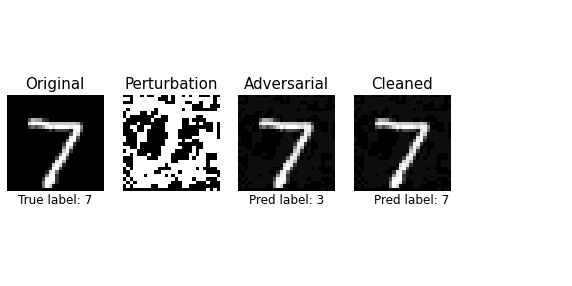

<Figure size 1440x144 with 0 Axes>

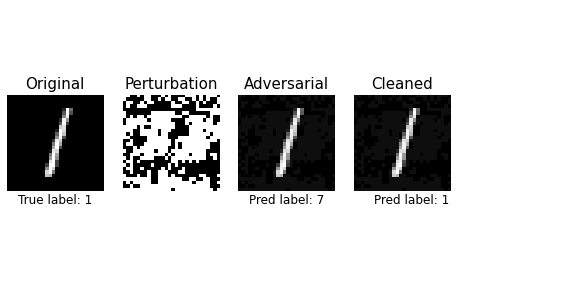

<Figure size 1440x144 with 0 Axes>

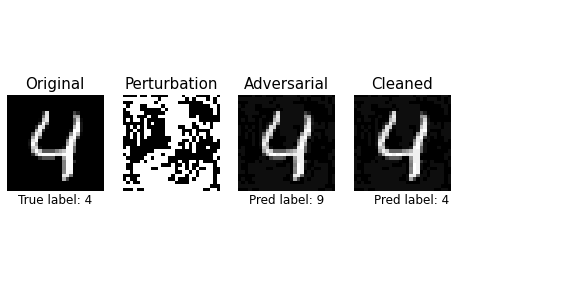

<Figure size 1440x144 with 0 Axes>

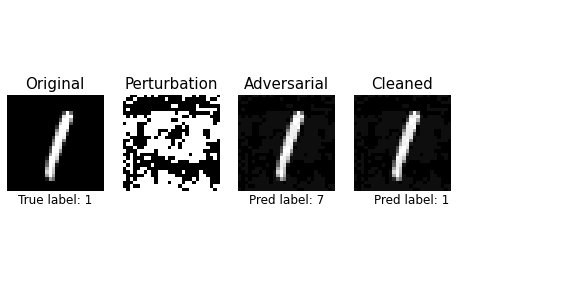

<Figure size 1440x144 with 0 Axes>

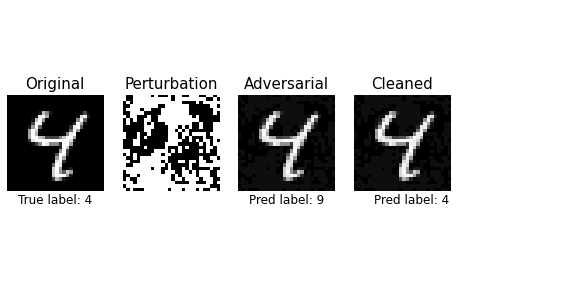

<Figure size 1440x144 with 0 Axes>

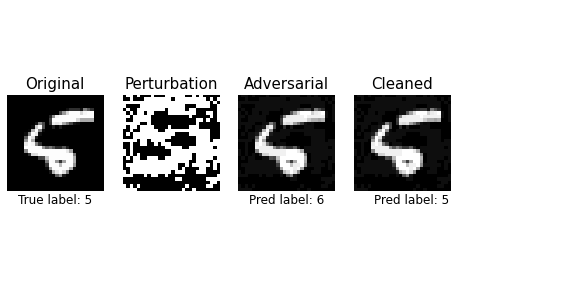

<Figure size 1440x144 with 0 Axes>

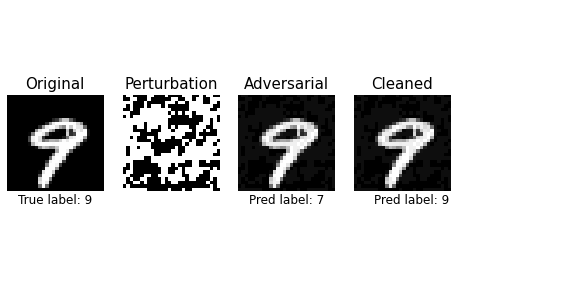

In [283]:
diff_idx2 = find_diff_classes(y_test, test_fgsm_preds2, n=10)
print(diff_idx2)
for i in diff_idx2:
    display_quad(x_test[i], x_test_fgsm_imgs2[i], x_test_fgsm_perts2[i], clean_fgsm_img_dense_autoenc_reshape2[i], y_test[i], test_fgsm_preds2[i], after_dense_autoenc_predicts2[i])

### OneStepLessLikely

In [331]:
clean_onest_img_dense_autoenc_reshape2 = clean_onest_img_dense_autoenc2.reshape((len(x_test_dense),28,28,1))
print(clean_onest_img_dense_autoenc_reshape2.shape)
after_dense_autoenc_predicts_onest2 = model_2.predict(clean_onest_img_dense_autoenc_reshape2)
after_dense_score_onest2 = model_2.evaluate(clean_onest_img_dense_autoenc_reshape2, y_test_dense_preprocessed)

(10000, 28, 28, 1)
10000/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [332]:
print('Default Model after cleaning OneStepLessLikely perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score_onest2[0]} mae: {after_dense_score_onest2[1]} accuracy: {after_dense_score_onest2[2]}')

Default Model after cleaning OneStepLessLikely perturbed images with Dense Autoencoder:
loss: 0.1441537865624834 mae: 0.009438445791602135 accuracy: 0.9573000073432922


[0, 4, 5, 6, 8, 9, 12, 18]


<Figure size 1440x144 with 0 Axes>

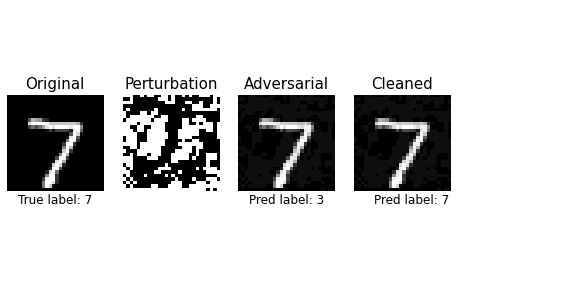

<Figure size 1440x144 with 0 Axes>

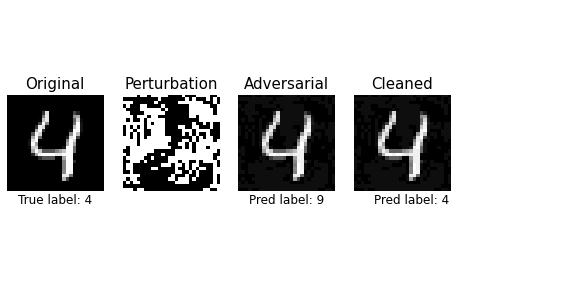

<Figure size 1440x144 with 0 Axes>

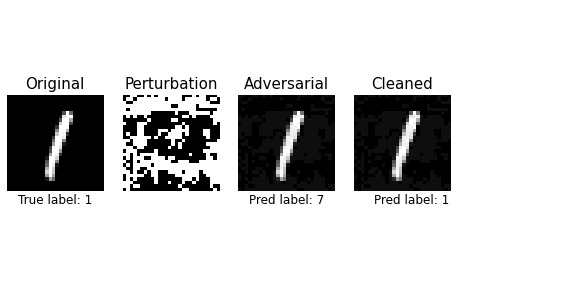

<Figure size 1440x144 with 0 Axes>

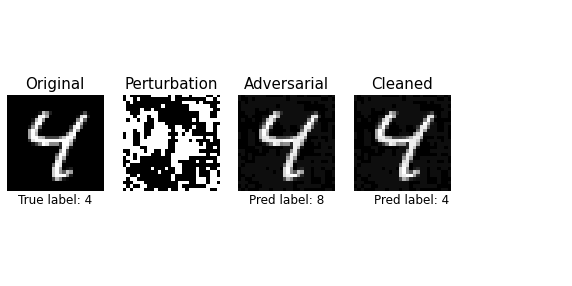

<Figure size 1440x144 with 0 Axes>

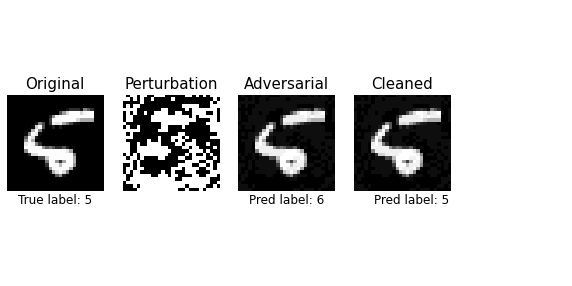

<Figure size 1440x144 with 0 Axes>

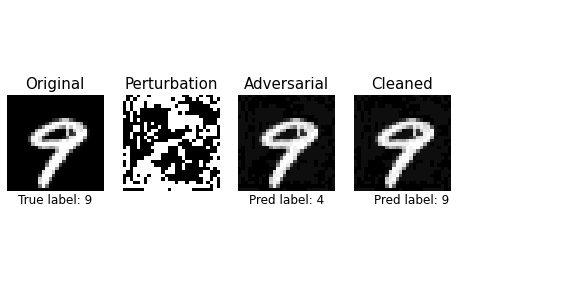

<Figure size 1440x144 with 0 Axes>

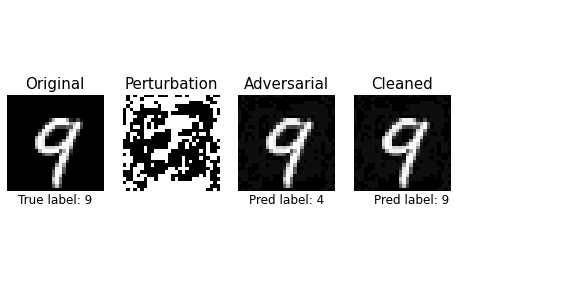

<Figure size 1440x144 with 0 Axes>

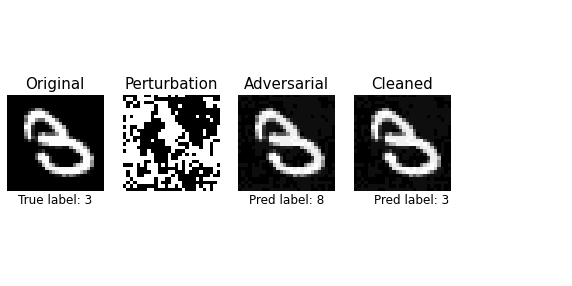

In [242]:
diff_idx2 = find_diff_classes(y_test, test_onest_preds2, n=20)
print(diff_idx2)
for i in diff_idx2:
    display_quad(x_test[i], x_test_onest_imgs2[i], x_test_onest_perts2[i], clean_onest_img_dense_autoenc_reshape2[i], y_test[i], test_onest_preds2[i], after_dense_autoenc_predicts_onest2[i])

### BIM

In [102]:
clean_bim_img_dense_autoenc_reshape2 = clean_bim_img_dense_autoenc2.reshape((len(x_test_dense),28,28,1))
print(clean_bim_img_dense_autoenc_reshape2.shape)
after_dense_autoenc_predicts_bim2 = model_2.predict(clean_bim_img_dense_autoenc_reshape2)
after_dense_score_bim2 = model_2.evaluate(clean_bim_img_dense_autoenc_reshape2, y_test_dense_preprocessed)

(10000, 28, 28, 1)
10000/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [103]:
print('Default Model after cleaning BIM perturbed images with Dense Autoencoder:')
print(f'loss: {after_dense_score_bim2[0]} mae: {after_dense_score_bim2[1]} accuracy: {after_dense_score_bim2[2]}')

Default Model after cleaning BIM perturbed images with Dense Autoencoder:
loss: 0.2552560028415053 mae: 0.010629787109792233 accuracy: 0.9501000046730042


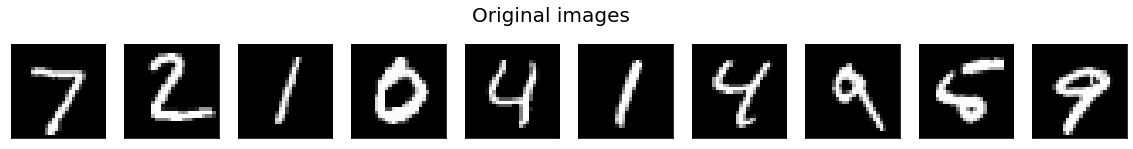

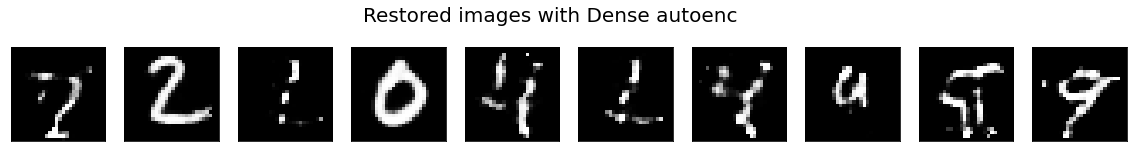

In [104]:
display_pair2(x_test,clean_bim_img_dense_autoenc_reshape2, 'Dense')

In [314]:
diff_idx2 = find_diff_classes(y_test, test_bim_preds2, n=10)
print(diff_idx2)
for i in diff_idx2:
    display_quad(x_test[i], x_test_bim_imgs2[i], x_test_bim_perts2[i], clean_bim_img_dense_autoenc_reshape2[i], y_test[i], test_bim_preds2[i], after_dense_autoenc_predicts_bim2[i])

[]


## Conv autoencoder

In [79]:
autoencoder_conv = tf.keras.models.load_model(os.path.join('saved_models','autoenc_clean_clean'))

ERROR! Session/line number was not unique in database. History logging moved to new session 654


#### FGSM

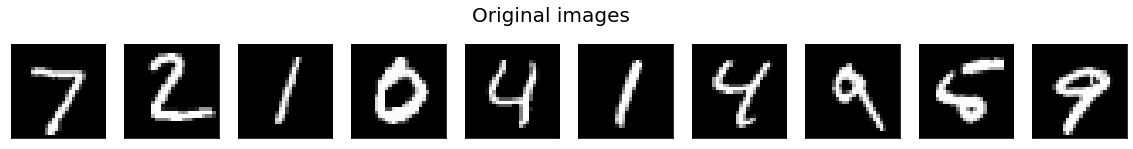

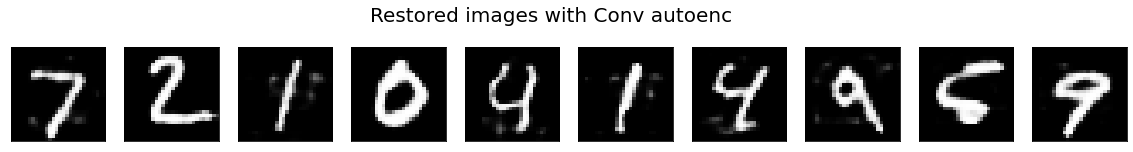

In [92]:
after_conv_pred2 = autoencoder_conv.predict(x_test_fgsm_imgs2)
display_pair2(x_test, after_conv_pred2, 'Conv')

In [206]:
len(after_conv_pred2[0])

28

In [247]:
after_conv_score2 = model_2.evaluate(after_conv_pred2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [248]:
print('Default Model after cleaning FGSM perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score2[0]} mae: {after_conv_score2[1]} accuracy: {after_conv_score2[2]}') 

Default Model after cleaning FGSM perturbed images with Conv Autoencoder:
loss: 0.36036822415410863 mae: 0.015095808543264866 accuracy: 0.9297999739646912


In [249]:
preds_after_conv_on_default_fgsm = model_2.predict(after_conv_pred2)
preds_after_conv_on_default_fgsm[0]

array([7.4158860e-11, 4.6771406e-15, 1.4177217e-11, 3.5082273e-06,
       8.3754622e-21, 1.5267079e-14, 1.8210150e-19, 9.9999654e-01,
       3.6007895e-11, 1.0483215e-11], dtype=float32)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


<Figure size 1440x144 with 0 Axes>

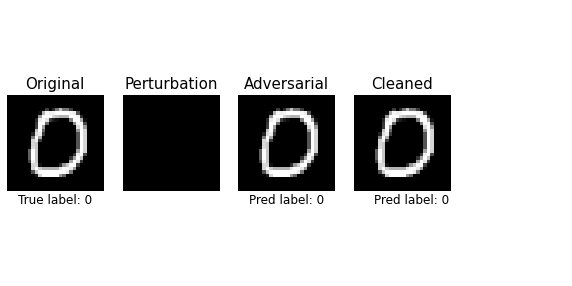

<Figure size 1440x144 with 0 Axes>

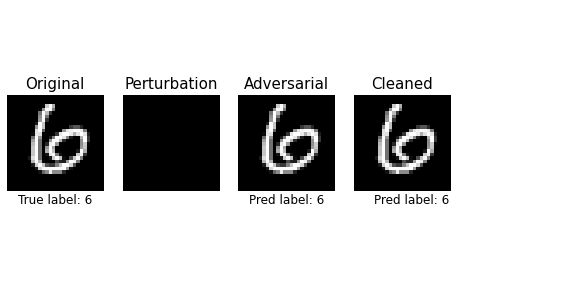

<Figure size 1440x144 with 0 Axes>

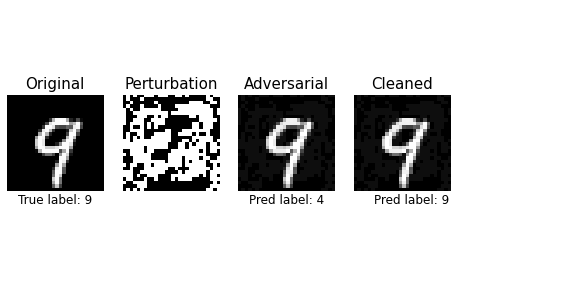

<Figure size 1440x144 with 0 Axes>

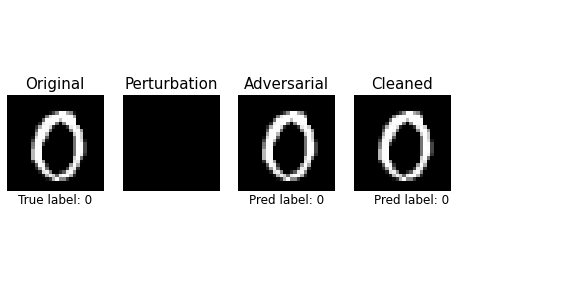

<Figure size 1440x144 with 0 Axes>

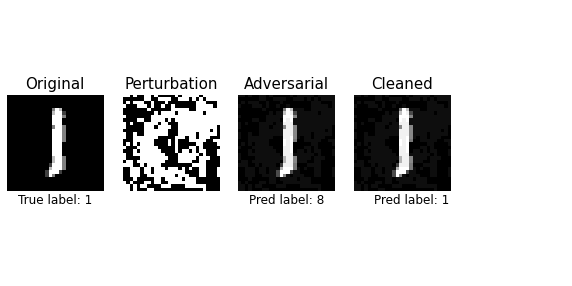

<Figure size 1440x144 with 0 Axes>

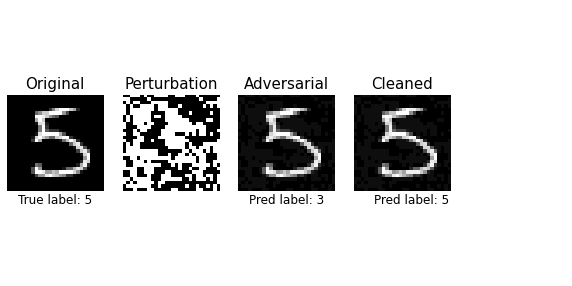

<Figure size 1440x144 with 0 Axes>

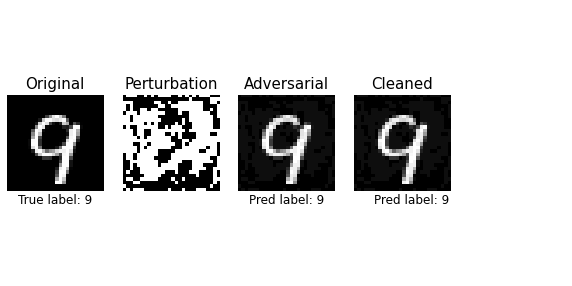

<Figure size 1440x144 with 0 Axes>

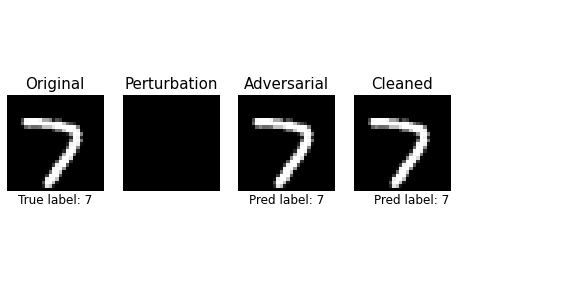

<Figure size 1440x144 with 0 Axes>

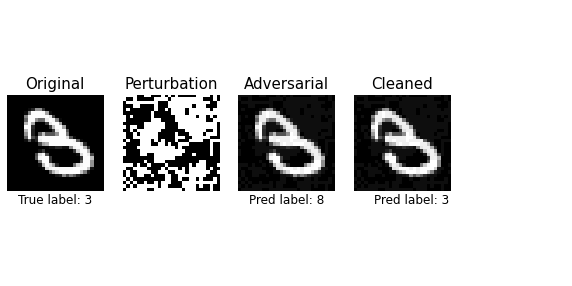

<Figure size 1440x144 with 0 Axes>

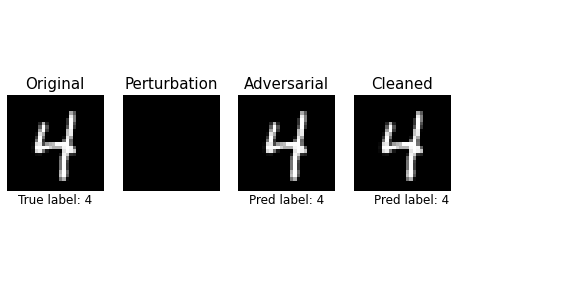

<Figure size 1440x144 with 0 Axes>

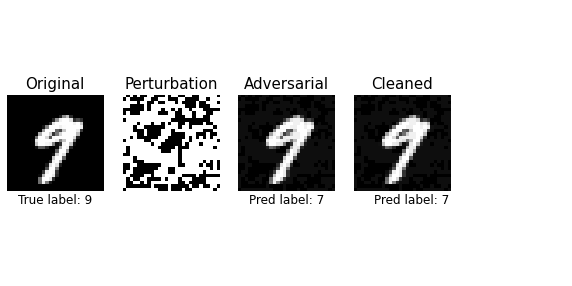

<Figure size 1440x144 with 0 Axes>

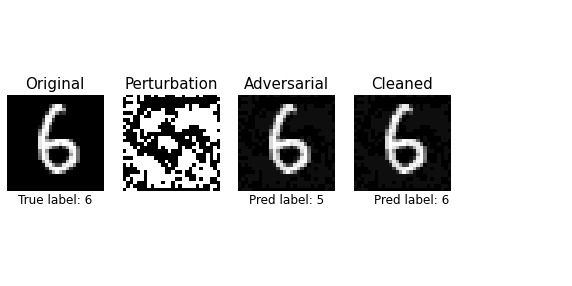

<Figure size 1440x144 with 0 Axes>

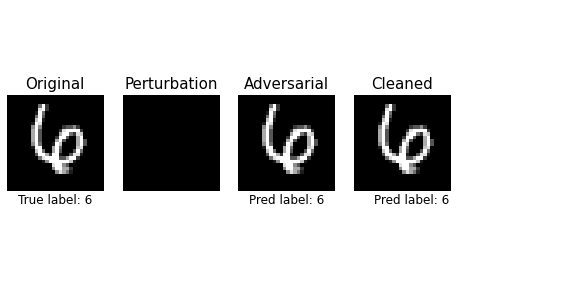

<Figure size 1440x144 with 0 Axes>

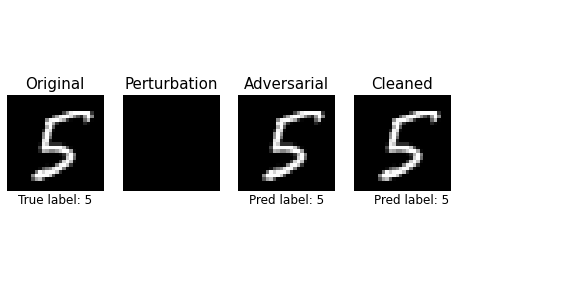

<Figure size 1440x144 with 0 Axes>

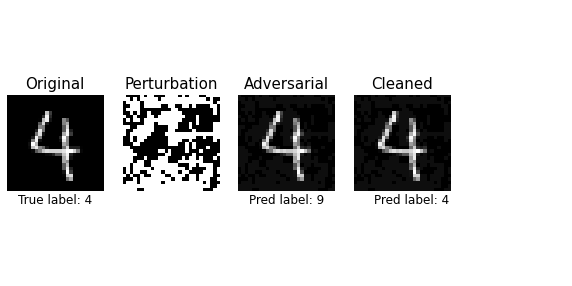

<Figure size 1440x144 with 0 Axes>

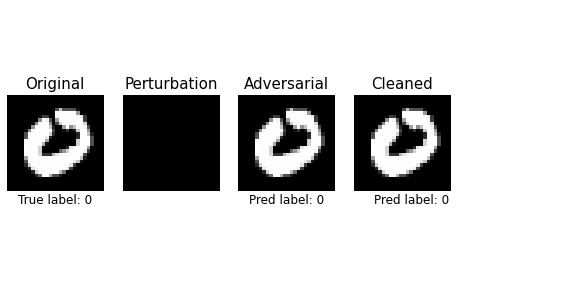

<Figure size 1440x144 with 0 Axes>

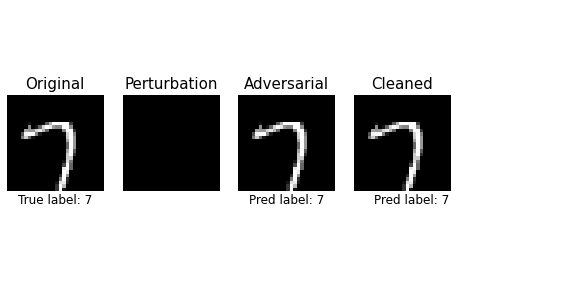

<Figure size 1440x144 with 0 Axes>

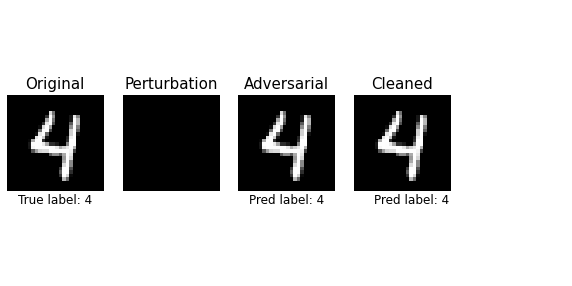

<Figure size 1440x144 with 0 Axes>

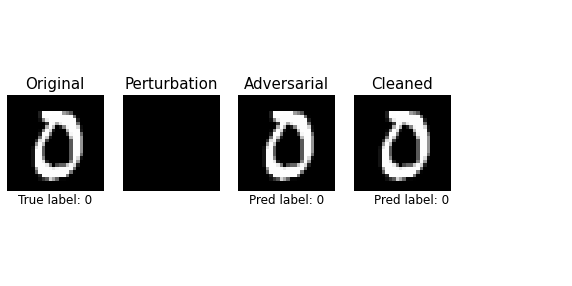

<Figure size 1440x144 with 0 Axes>

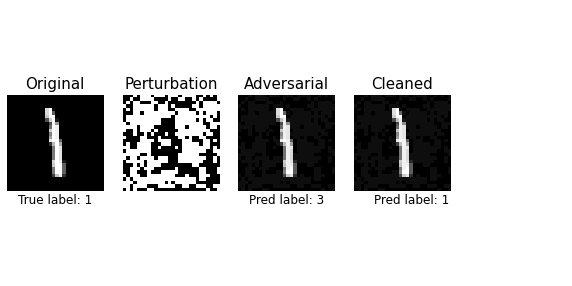

<Figure size 1440x144 with 0 Axes>

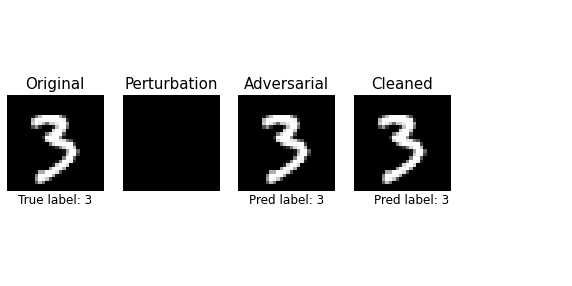

<Figure size 1440x144 with 0 Axes>

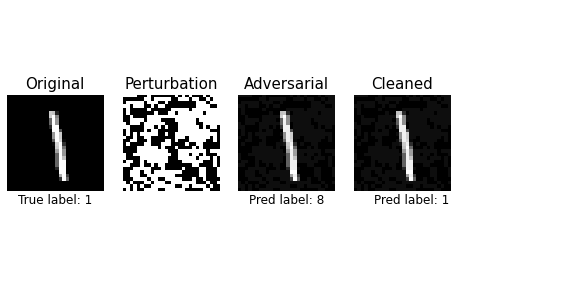

<Figure size 1440x144 with 0 Axes>

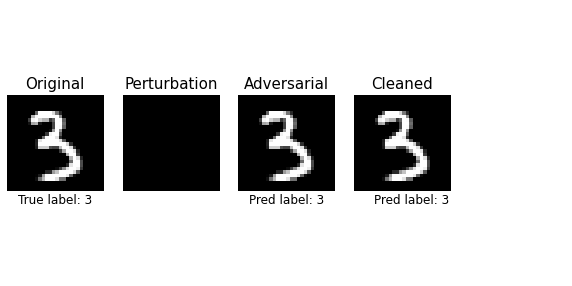

<Figure size 1440x144 with 0 Axes>

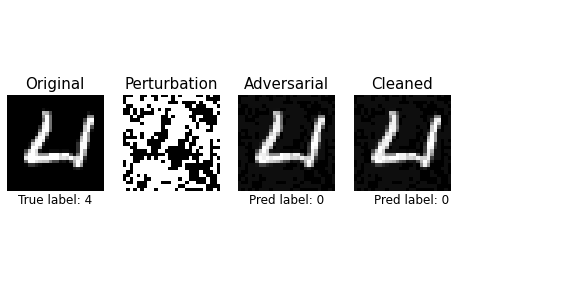

<Figure size 1440x144 with 0 Axes>

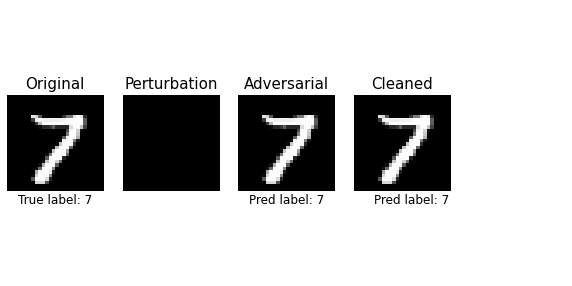

<Figure size 1440x144 with 0 Axes>

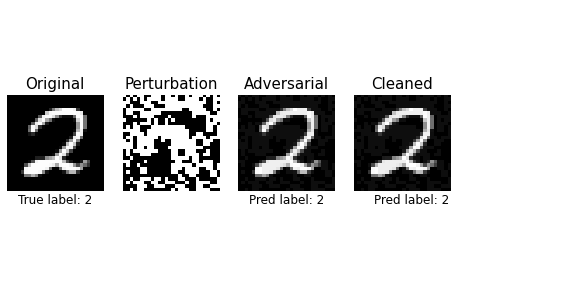

<Figure size 1440x144 with 0 Axes>

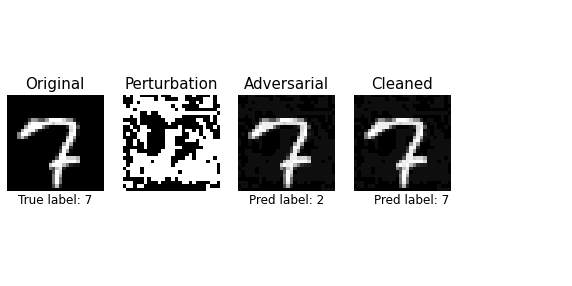

<Figure size 1440x144 with 0 Axes>

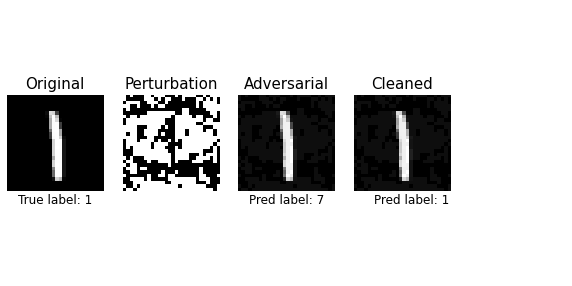

<Figure size 1440x144 with 0 Axes>

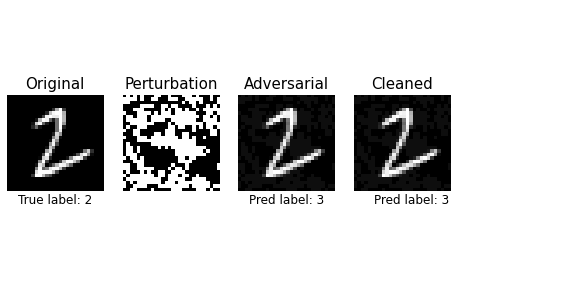

<Figure size 1440x144 with 0 Axes>

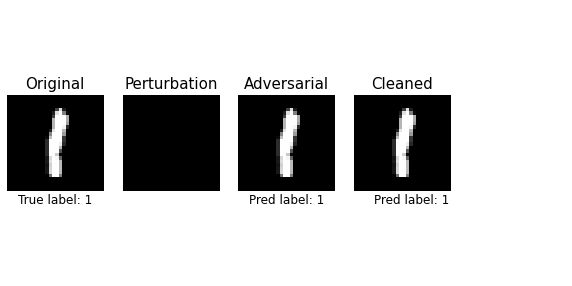

In [251]:
diff_idx2 = find_diff_classes(y_test, after_conv_pred2, n=40)
print(diff_idx2)
for i in range(10, len(diff_idx2)):
    display_quad(x_test[i], x_test_fgsm_imgs2[i], x_test_fgsm_perts2[i], clean_fgsm_img_dense_autoenc_reshape2[i], y_test[i], test_fgsm_preds2[i], preds_after_conv_on_default_fgsm[i])
    

#### OneStepLessLikely

In [252]:
after_conv_pred_onest2 = autoencoder_conv.predict(x_test_onest_imgs2)
after_conv_score_onest2 = model_2.evaluate(after_conv_pred_onest2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [253]:
print('Default Model after cleaning OneStepLessLikely perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score_onest2[0]} mae: {after_conv_score_onest2[1]} accuracy: {after_conv_score_onest2[2]}') 

Default Model after cleaning OneStepLessLikely perturbed images with Conv Autoencoder:
loss: 0.1663834551231812 mae: 0.010918243788182735 accuracy: 0.9502000212669373


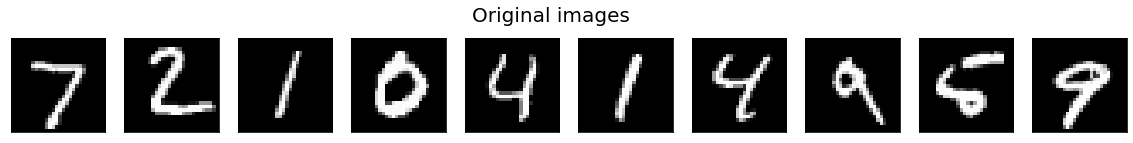

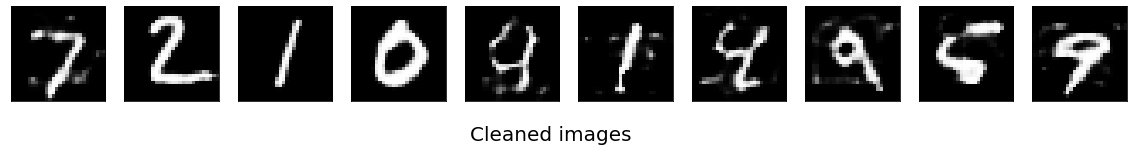

In [139]:
display_pair2(x_test, after_conv_pred_onest2)

In [254]:
preds_after_conv_on_default_onest = model_2.predict(after_conv_pred_onest2)
preds_after_conv_on_default_onest[0]

array([7.4158860e-11, 4.6771406e-15, 1.4177217e-11, 3.5082273e-06,
       8.3754622e-21, 1.5267079e-14, 1.8210150e-19, 9.9999654e-01,
       3.6007895e-11, 1.0483215e-11], dtype=float32)

<Figure size 1440x144 with 0 Axes>

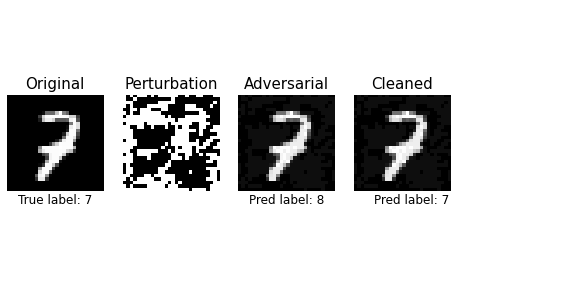

<Figure size 1440x144 with 0 Axes>

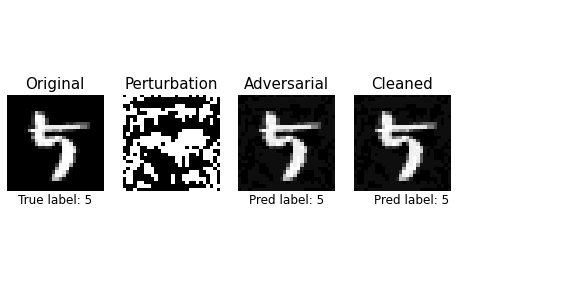

<Figure size 1440x144 with 0 Axes>

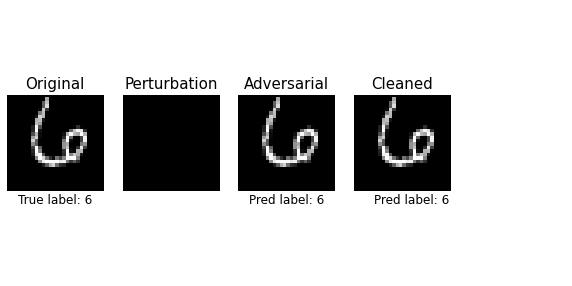

<Figure size 1440x144 with 0 Axes>

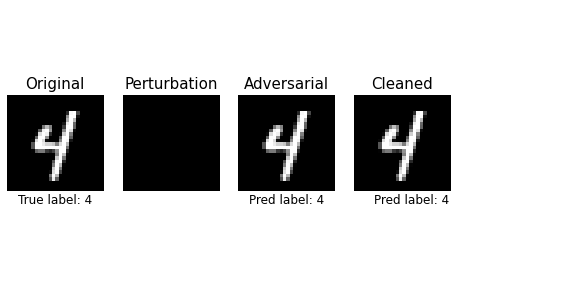

<Figure size 1440x144 with 0 Axes>

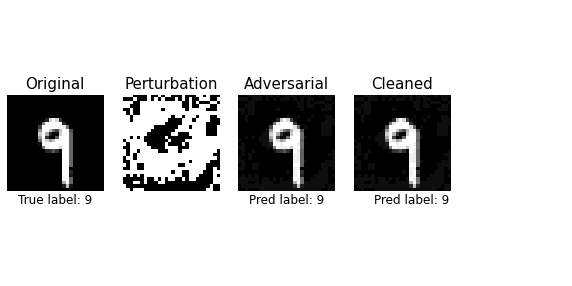

<Figure size 1440x144 with 0 Axes>

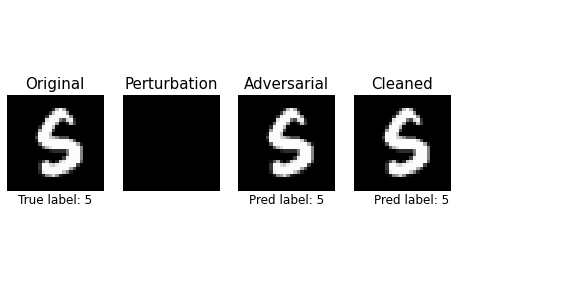

<Figure size 1440x144 with 0 Axes>

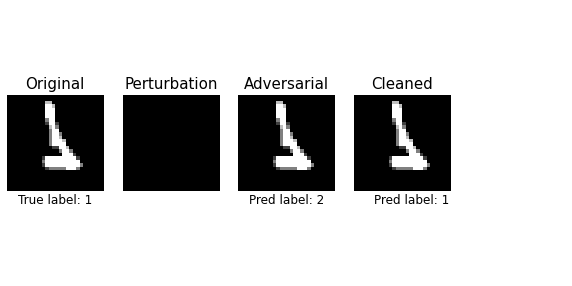

<Figure size 1440x144 with 0 Axes>

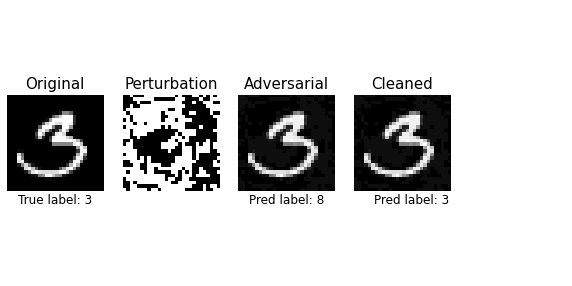

<Figure size 1440x144 with 0 Axes>

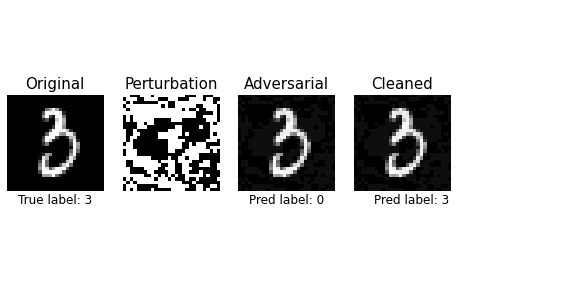

<Figure size 1440x144 with 0 Axes>

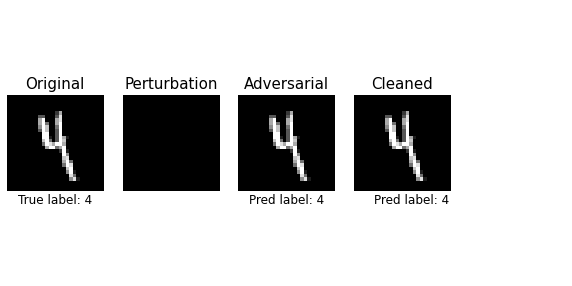

<Figure size 1440x144 with 0 Axes>

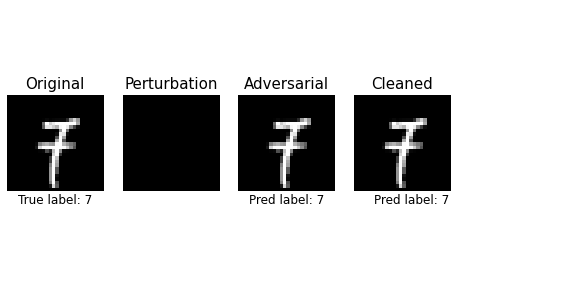

<Figure size 1440x144 with 0 Axes>

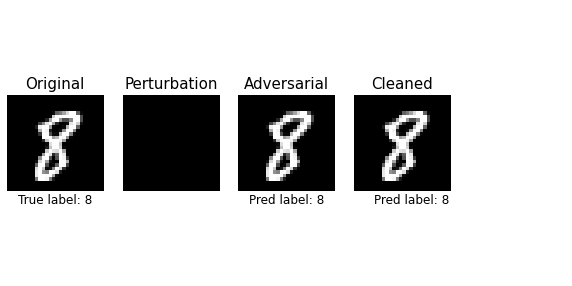

<Figure size 1440x144 with 0 Axes>

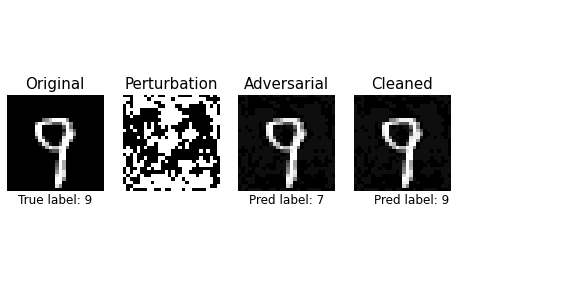

<Figure size 1440x144 with 0 Axes>

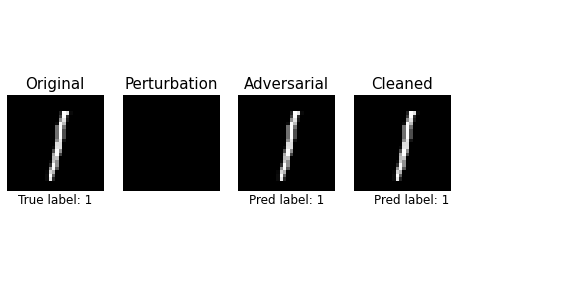

<Figure size 1440x144 with 0 Axes>

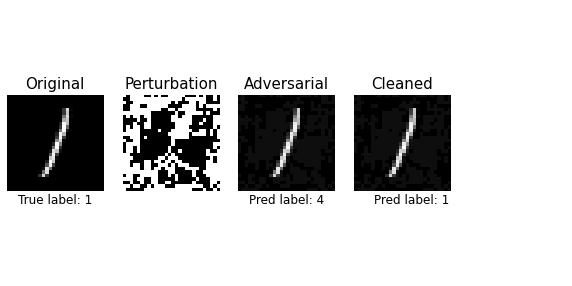

<Figure size 1440x144 with 0 Axes>

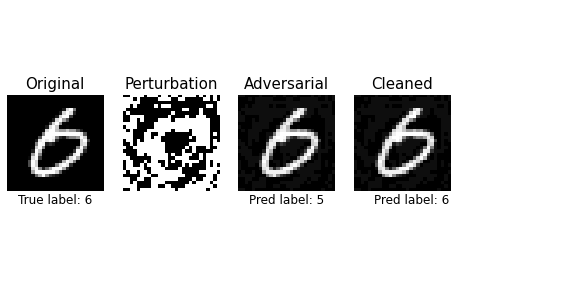

<Figure size 1440x144 with 0 Axes>

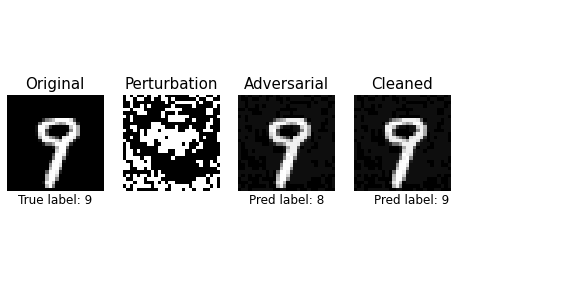

<Figure size 1440x144 with 0 Axes>

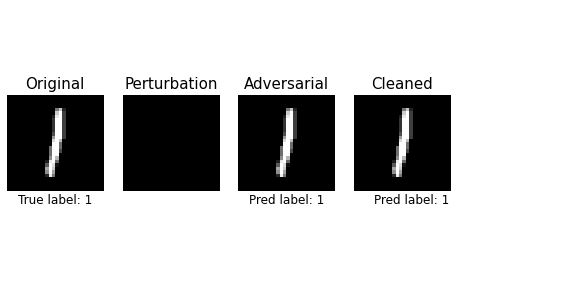

<Figure size 1440x144 with 0 Axes>

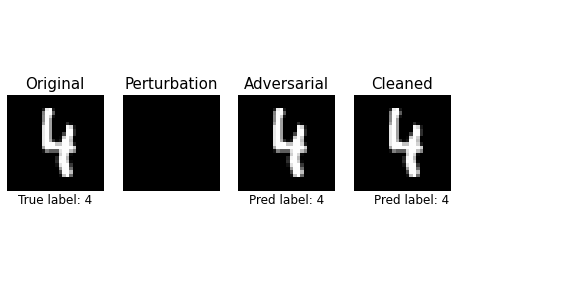

<Figure size 1440x144 with 0 Axes>

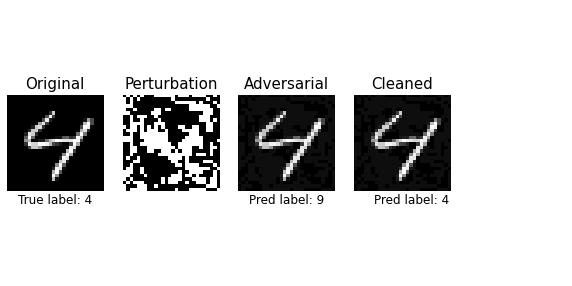

<Figure size 1440x144 with 0 Axes>

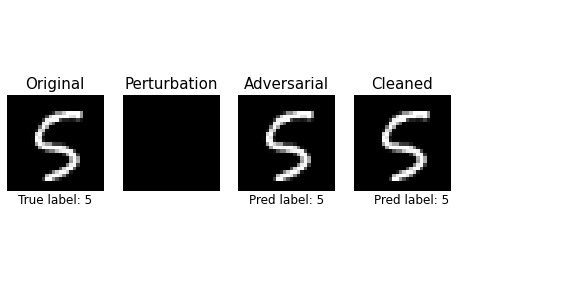

<Figure size 1440x144 with 0 Axes>

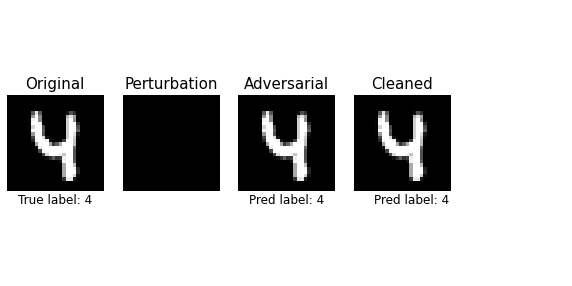

<Figure size 1440x144 with 0 Axes>

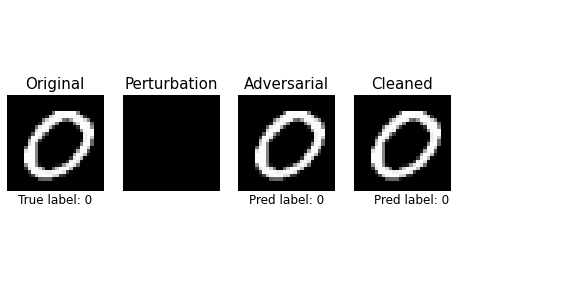

<Figure size 1440x144 with 0 Axes>

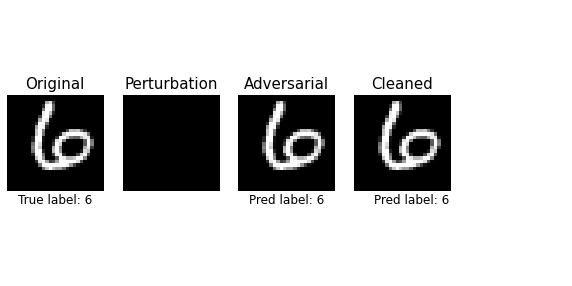

<Figure size 1440x144 with 0 Axes>

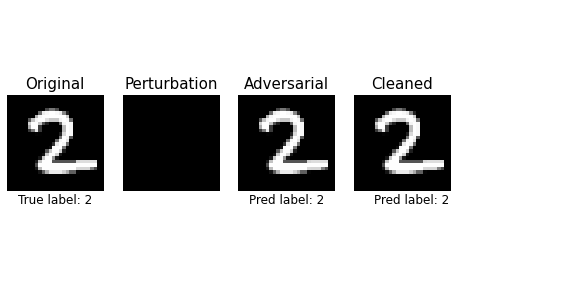

<Figure size 1440x144 with 0 Axes>

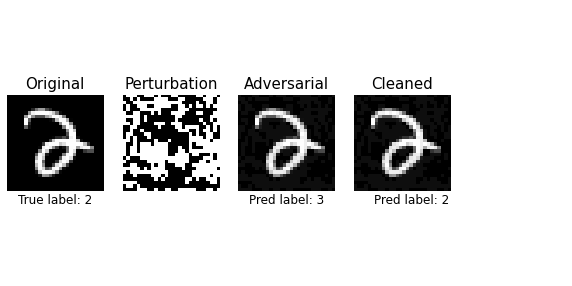

<Figure size 1440x144 with 0 Axes>

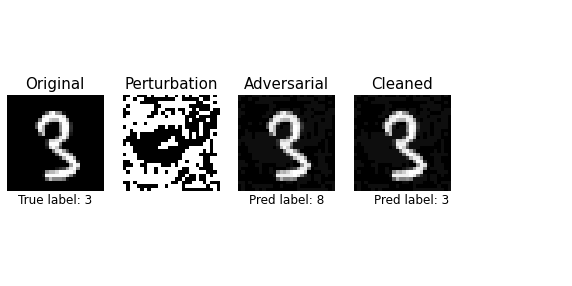

<Figure size 1440x144 with 0 Axes>

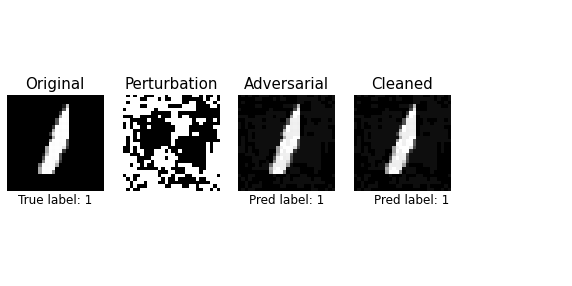

<Figure size 1440x144 with 0 Axes>

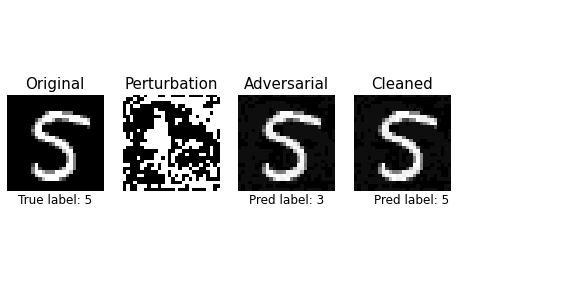

<Figure size 1440x144 with 0 Axes>

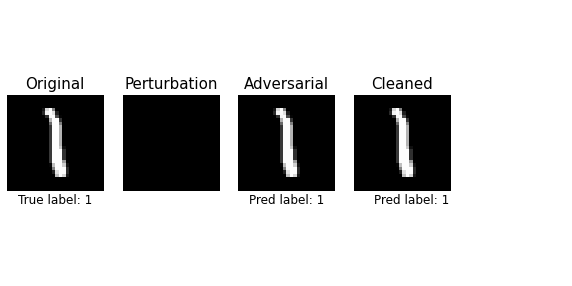

<Figure size 1440x144 with 0 Axes>

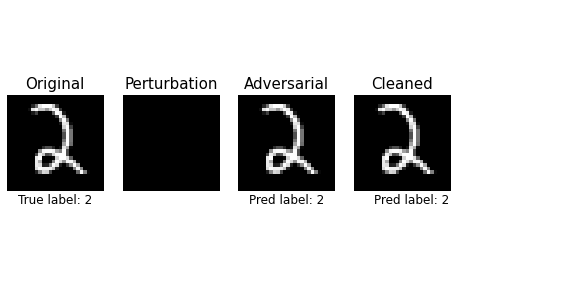

<Figure size 1440x144 with 0 Axes>

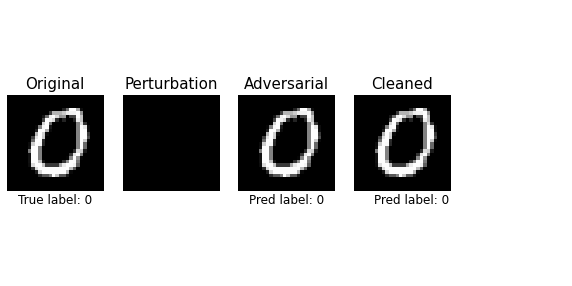

<Figure size 1440x144 with 0 Axes>

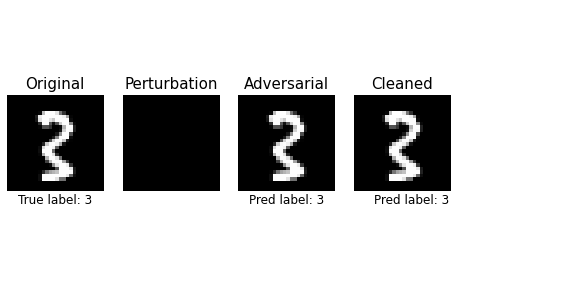

<Figure size 1440x144 with 0 Axes>

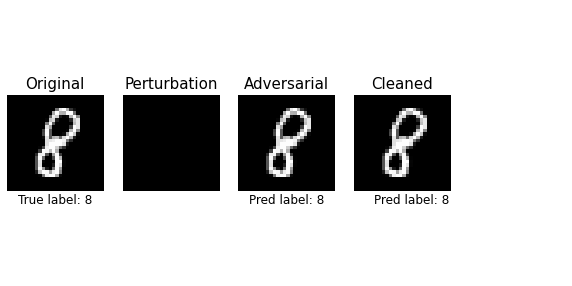

<Figure size 1440x144 with 0 Axes>

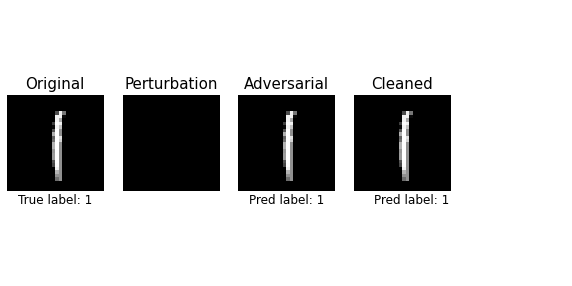

<Figure size 1440x144 with 0 Axes>

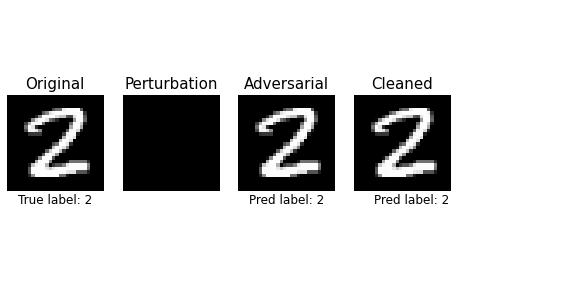

<Figure size 1440x144 with 0 Axes>

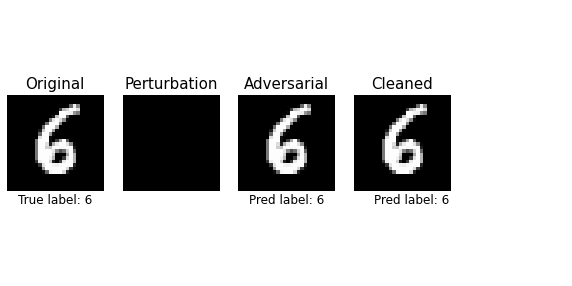

<Figure size 1440x144 with 0 Axes>

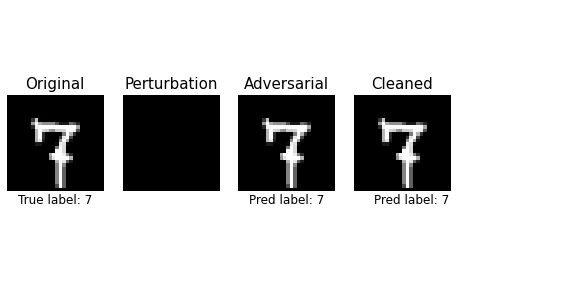

<Figure size 1440x144 with 0 Axes>

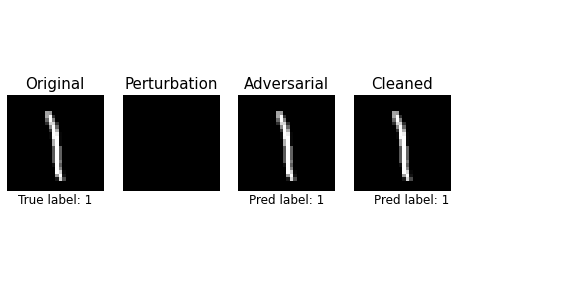

<Figure size 1440x144 with 0 Axes>

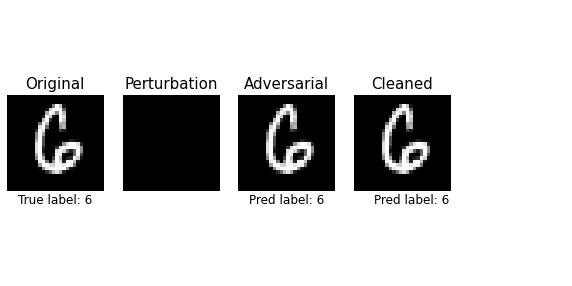

<Figure size 1440x144 with 0 Axes>

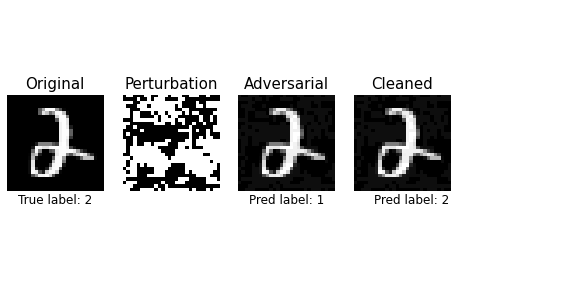

<Figure size 1440x144 with 0 Axes>

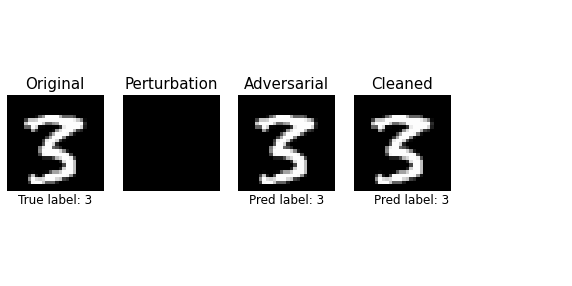

<Figure size 1440x144 with 0 Axes>

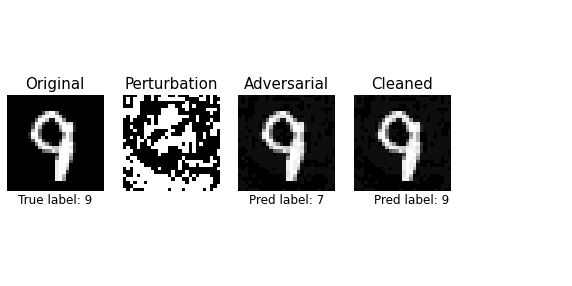

<Figure size 1440x144 with 0 Axes>

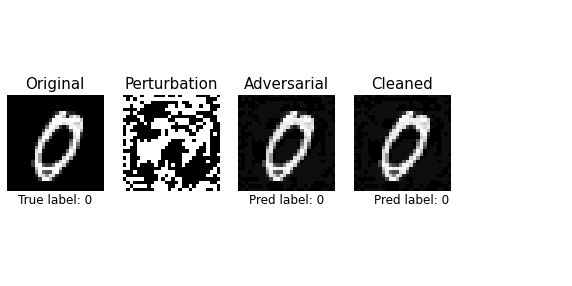

<Figure size 1440x144 with 0 Axes>

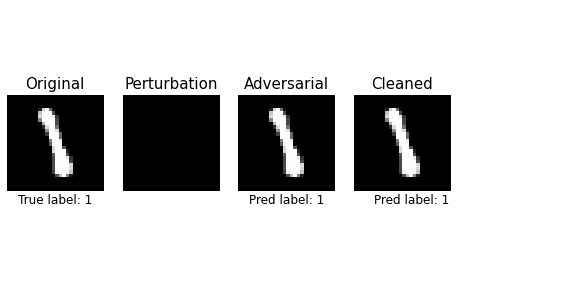

<Figure size 1440x144 with 0 Axes>

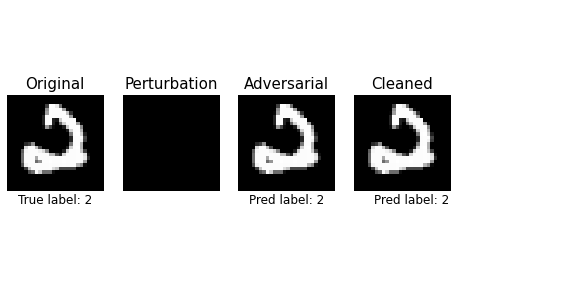

<Figure size 1440x144 with 0 Axes>

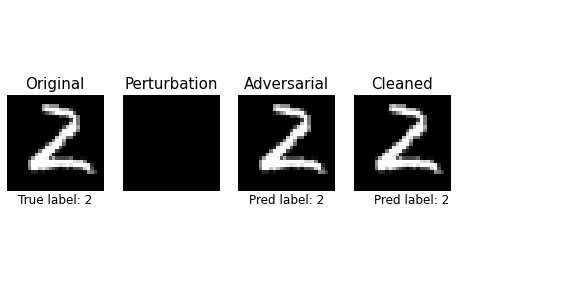

<Figure size 1440x144 with 0 Axes>

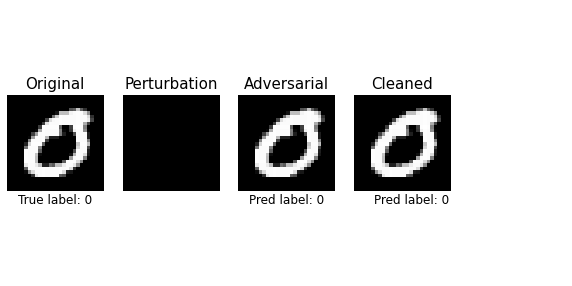

<Figure size 1440x144 with 0 Axes>

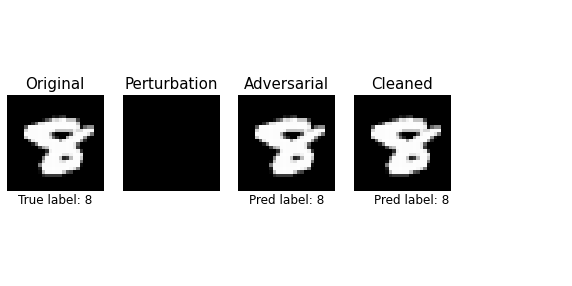

<Figure size 1440x144 with 0 Axes>

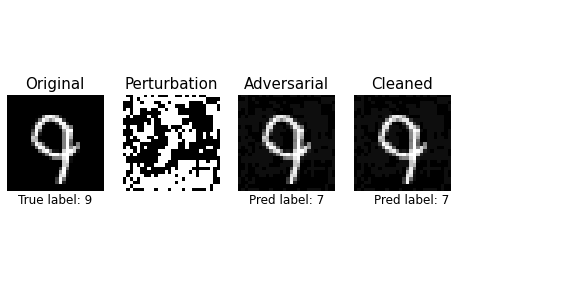

In [258]:
diff_idx2 = find_diff_classes(y_test, after_conv_pred_onest2, n=1000)
#print(diff_idx2)
for i in range(950,len(diff_idx2)):
    display_quad(x_test[i], x_test_onest_imgs2[i], x_test_onest_perts2[i], clean_onest_img_dense_autoenc_reshape2[i], y_test[i], test_onest_preds2[i], preds_after_conv_on_default_onest[i])

#### BIM

In [259]:
after_conv_pred_bim2 = autoencoder_conv.predict(x_test_bim_imgs2)
after_conv_score_bim2 = model_2.evaluate(after_conv_pred_bim2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [260]:
print('Default Model after cleaning BIM perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score_bim2[0]} mae: {after_conv_score_bim2[1]} accuracy: {after_conv_score_bim2[2]}') 

Default Model after cleaning BIM perturbed images with Conv Autoencoder:
loss: 2.383131712269783 mae: 0.043173227459192276 accuracy: 0.7853000164031982


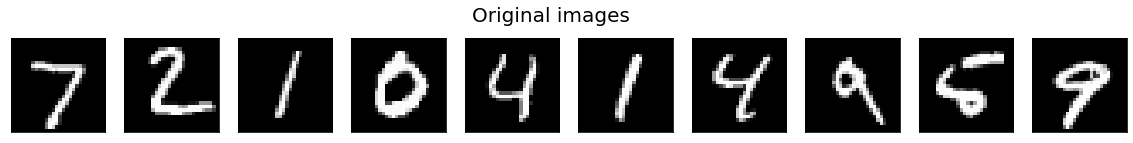

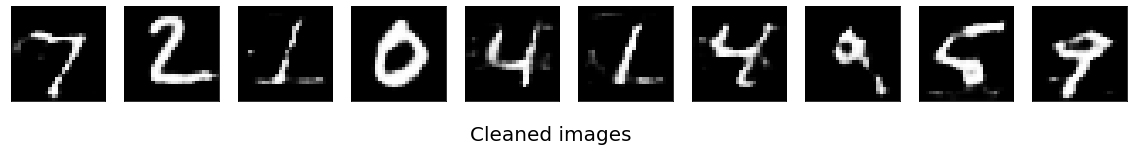

In [142]:
#eps = 1.0
display_pair2(x_test, after_conv_pred_bim2)

In [ ]:
preds_after_conv_on_default_bim = model_2.predict(after_conv_pred_bim2)
preds_after_conv_on_default_bim[0]

In [ ]:
diff_idx2 = find_diff_classes(y_test, after_conv_pred_bim2, n=10)
print(diff_idx2)
for i in diff_idx2:
    display_quad(x_test[i], x_test_bim_imgs2[i], x_test_bim_perts2[i], clean_bim_img_dense_autoenc_reshape2[i], y_test[i], test_bim_preds2[i], preds_after_conv_on_default_bim[i])

#### FGVM

In [143]:
after_conv_pred_fgvm2 = autoencoder_conv.predict(x_test_fgvm_imgs2)
after_conv_score_fgvm2 = model_2.evaluate(after_conv_pred_fgvm2, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [144]:
print('Default Model after cleaning BIM perturbed images with Conv Autoencoder:')
print(f'loss: {after_conv_score_fgvm2[0]} mae: {after_conv_score_fgvm2[1]} accuracy: {after_conv_score_fgvm2[2]}') 

Default Model after cleaning BIM perturbed images with Conv Autoencoder:
loss: 1.3507014260490822 mae: 0.008851044811308384 accuracy: 0.9574000239372253


In [ ]:
#eps = 1.0
display_pair2(x_test, after_conv_pred_fgvm2)

In [ ]:
diff_idx2 = find_diff_classes(y_test, after_conv_pred_fgvm2, n=10)
print(diff_idx2)
for i in diff_idx:
    display_quad(x_test[i], x_test_fgvm_imgs2[i], x_test_fgvm_perts2[i], clean_fgvm_img_dense_autoenc_reshape2[i], y_test[i], test_fgvm_preds2[i], after_conv_pred_fgvm2[i])